In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from scipy.stats import zscore
from sklearn.impute import KNNImputer
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy import stats
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis

## Bring the Data

In [2]:
from pathlib import Path
print(Path.cwd())

from os import walk

#This is the folder path, replace to your own local path
dir_path = r'C:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Sang_Code_Processing_2024\0. Raw data\Year 3\Desigo\BTU\Geowell'

file_list = []
for (dir_path, dir_names, file_names) in walk(dir_path):
    file_list.extend(file_names)
    # don't look inside any subdirectory
    break
print(file_list)

c:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Final_Processing_Code_2024\Code Year3
['HZ_BTU2(Gwell_L)_energy_Y3_raw.csv', 'HZ_BTU2(Gwell_L)_flow_Y3_raw.csv', 'HZ_BTU2(Gwell_L)_ReturnT_Y3_raw.csv', 'HZ_BTU2(Gwell_L)_SupplyT_Y3_raw.csv', 'HZ_BTU3(Gwell_R)_energy_Y3_raw.csv', 'HZ_BTU3(Gwell_R)_flow_Y3_raw.csv', 'HZ_BTU3(Gwell_R)_ReturnT_Y3_raw.csv', 'HZ_BTU3(Gwell_R)_SupplyT_Y3_raw.csv', 'HZ_BTU4(Gwell_Com)_energy_Y3_raw.csv', 'HZ_BTU4(Gwell_Com)_flow_Y3_raw.csv', 'HZ_BTU4(Gwell_Com)_ReturnT_Y3_raw.csv', 'HZ_BTU4(Gwell_Com)_SupplyT_Y3_raw.csv']


In [3]:
#IMPORTANT: If you get an error in reading the files do the following:
import os
Lst = []
for i in range(0, len(file_list)):
    # Construct the full path for each file
    file_path = os.path.join(dir_path, file_list[i])
    # Use the full path to read the CSV file
    data = pd.read_csv(file_path, parse_dates=['Timestamp'], index_col=[0])
    filtered_df = data[data['QualityGood'] == True]
    print(len(filtered_df))
    Lst.append(filtered_df)

523289
523287
523287
523287
523286
523284
523287
523287
523284
523283
523286
523284


In [4]:
Lst_diff = []
Lst_name = []
#Loop through the data frames
for i in range(0,len(Lst)):
    #Extract zone name (Zone 1, 2, etc.) and append the names to Lst_name
    zone_name = Lst[i].columns.values[0]
    Lst_name.append(zone_name)
    #Convert values to numeric type
    Z = pd.to_numeric(Lst[i][zone_name])
    #Based on the zone_name (column names) calculate diff between successive values
    temp = Z.diff()
    Lst_diff.append(temp.sort_values(ascending=True)[-100:-1].tolist())
    
# print (Lst_diff)

df = pd.DataFrame(Lst_diff).transpose()

df.columns = Lst_name
#Calculate the .75 quantile to get a sense of the distribution of the spread of the data
q_values = df.quantile(0.75)

In [5]:
q_values

BTU2(Gwell_L)_energy (BTUs)      17.068667
BTU2(Gwell_L)_flow (GPM)          7.430970
BTU2(Gwell_L)_ReturnT (F)         1.129274
BTU2(Gwell_L)_SupplyT (F)         0.311152
BTU3(Gwell_R)_energy (BTUs)      14.636985
BTU3(Gwell_R)_flow (GPM)          7.860251
BTU3(Gwell_R)_ReturnT (F)         1.156981
BTU3(Gwell_R)_SupplyT (F)         0.392570
BTU4(Gwell_Com)_energy (BTUs)    22.474334
BTU4(Gwell_Com)_flow (GPM)       14.948429
BTU4(Gwell_Com)_ReturnT (F)       3.103882
BTU4(Gwell_Com)_SupplyT (F)       0.602362
Name: 0.75, dtype: float64

In [7]:
Lst_Slab = []
Lst_name = []
#Initialize an empty DataFrame to compile resampled data from each DataFrame in Lst
Zone_DF = pd.DataFrame()
res = 1
#This part will take care of timestamp corrections, ensuring the output is always EST!
for i in range(0,len(Lst)):
    #Convert the index of the current DataFrame to datetime format with UTC timezone
    Lst[i].index = pd.to_datetime(Lst[i].index, errors='coerce', utc=True, format='mixed')
    #Convert the timezone of the index from UTC to US/Eastern
    Lst[i].index = Lst[i].index.tz_convert('US/Eastern')
    #Resample the DataFrame to a 1-minute frequency using the mean for aggregation. (This is for analysis)
    #forward fill missing data resulting from the resampling.
    Lst[i] = Lst[i].resample("1T").mean().ffill()
    #Extract the name of the first column of the DataFrame.
    zone_name = Lst[i].columns.values[0]
    Lst_name.append(zone_name)
    #Convert the specified column's data to numeric to ensure consistency for calculations.
    Z = pd.to_numeric(Lst[i][zone_name])
    Lst_Slab.append(Z.tolist())
    #Create a new column in 'Zone_DF' with the name of the current zone.
    Zone_DF[zone_name] = pd.Series(Z, index=Lst[i].index)
    
Zone_DF

C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\3145754127.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\3145754127.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\3145754127.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\3145754127.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  Lst[i] = Lst[i].resample("1T").mean().ffill()
C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\3145754127.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, plea

BTU2(Gwell_L)_energy (BTUs)  \
Timestamp                                                
2022-06-01 00:00:00-04:00                          0.0   
2022-06-01 00:01:00-04:00                          0.0   
2022-06-01 00:02:00-04:00                          0.0   
2022-06-01 00:03:00-04:00                          0.0   
2022-06-01 00:04:00-04:00                          0.0   
...                                                ...   
2023-05-31 23:55:00-04:00                          0.0   
2023-05-31 23:56:00-04:00                          0.0   
2023-05-31 23:57:00-04:00                          0.0   
2023-05-31 23:58:00-04:00                          0.0   
2023-05-31 23:59:00-04:00                          0.0   

                           BTU2(Gwell_L)_flow (GPM)  \
Timestamp                                             
2022-06-01 00:00:00-04:00                       0.0   
2022-06-01 00:01:00-04:00                       0.0   
2022-06-01 00:02:00-04:00                       0.0   
2022-06-01 00:03:00-04:00                       0.0   
2022-06-01 00:04:00-04:00                       0.0   
...                                             ...   
2023-05-31 23:55:00-04:00                       0.0   
2023-05-31 23:56:00-04:00                       0.0   
2023-05-31 23:57:00-04:00                       0.0   
2023-05-31 23:58:00-04:00                       0.0   
2023-05-31 23:59:00-04:00                       0.0   

                           BTU2(Gwell_L)_ReturnT (F)  \
Timestamp                                              
2022-06-01 00:00:00-04:00                  75.242828   
2022-06-01 00:01:00-04:00                  75.239243   
2022-06-01 00:02:00-04:00                  75.229462   
2022-06-01 00:03:00-04:00                  75.227173   
2022-06-01 00:04:00-04:00                  75.202103   
...                                              ...   
2023-05-31 23:55:00-04:00                  73.670868   
2023-05-31 23:56:00-04:00                  73.673119   
2023-05-31 23:57:00-04:00                  73.662872   
2023-05-31 23:58:00-04:00                  73.670776   
2023-05-31 23:59:00-04:00                  73.667999   

                           BTU2(Gwell_L)_SupplyT (F)  \
Timestamp                                              
2022-06-01 00:00:00-04:00                  70.820366   
2022-06-01 00:01:00-04:00                  70.796852   
2022-06-01 00:02:00-04:00                  70.808212   
2022-06-01 00:03:00-04:00                  70.778770   
2022-06-01 00:04:00-04:00                  70.752434   
...                                              ...   
2023-05-31 23:55:00-04:00                  70.171722   
2023-05-31 23:56:00-04:00                  70.182915   
2023-05-31 23:57:00-04:00                  70.170509   
2023-05-31 23:58:00-04:00                  70.165970   
2023-05-31 23:59:00-04:00                  70.170174   

                           BTU3(Gwell_R)_energy (BTUs)  \
Timestamp                                                
2022-06-01 00:00:00-04:00                          0.0   
2022-06-01 00:01:00-04:00                          0.0   
2022-06-01 00:02:00-04:00                          0.0   
2022-06-01 00:03:00-04:00                          0.0   
2022-06-01 00:04:00-04:00                          0.0   
...                                                ...   
2023-05-31 23:55:00-04:00                          0.0   
2023-05-31 23:56:00-04:00                          0.0   
2023-05-31 23:57:00-04:00                          0.0   
2023-05-31 23:58:00-04:00                          0.0   
2023-05-31 23:59:00-04:00                          0.0   

                           BTU3(Gwell_R)_flow (GPM)  \
Timestamp                                             
2022-06-01 00:00:00-04:00                       0.0   
2022-06-01 00:01:00-04:00                       0.0   
2022-06-01 00:02:00-04:00                       0.0   
2022-06-01 00:03:00-04:00                       0.0   
2022-06-01 00

In [8]:
df = Zone_DF

In [9]:
print(df.index.min(), df.index.max())


2022-06-01 00:00:00-04:00 2023-05-31 23:59:00-04:00


## Remove Outliers

Z-score method

<Axes: xlabel='Timestamp'>

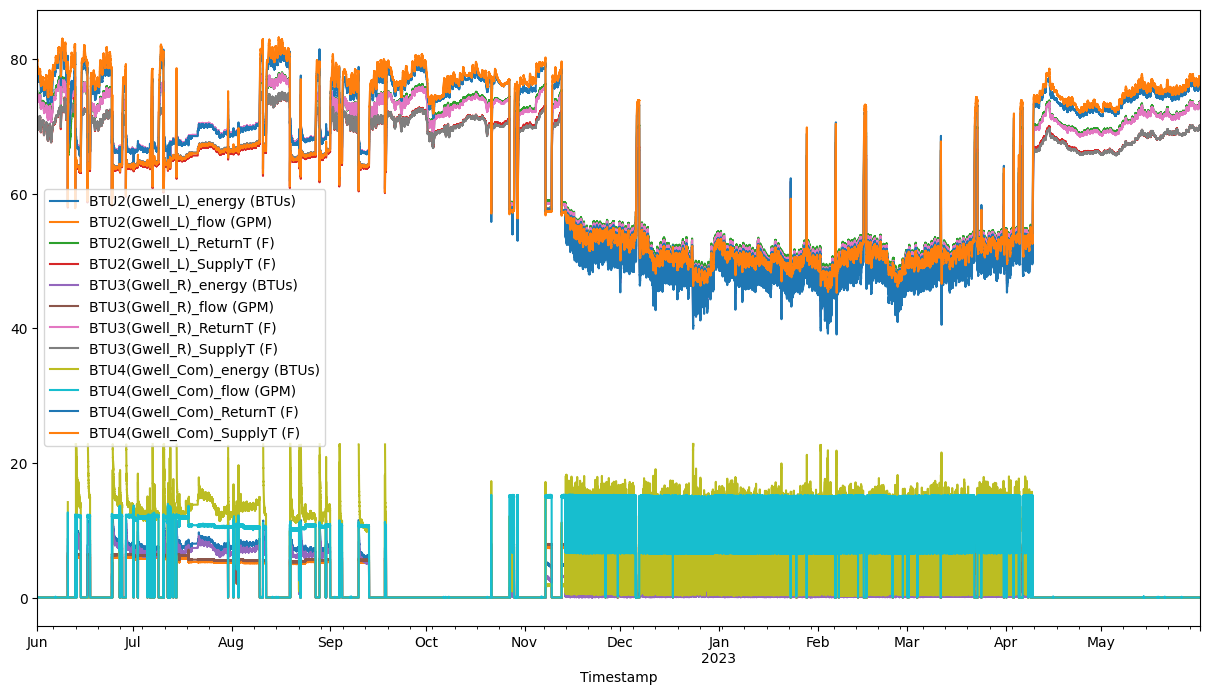

In [10]:
#Calculate Z-scores of the dataframe
z_scores = np.abs(stats.zscore(df))
# Define a threshold (e.g., 3 standard deviations)
threshold = 3
# Replace data points that are outliers with np.nan
df[(z_scores > threshold)] = np.nan

df.plot(figsize=(15, 8))

In [11]:
#Filter columns containing "(F)"
columns_with_F = [col for col in df.columns if "(F)" in col]
#Filter columns not containing "(F)"
columns_without_F = [col for col in df.columns if "(F)" not in col]

# Create two DataFrames based on the filter above
df_with_F = df[columns_with_F]
df_without_F = df[columns_without_F]

In [12]:
columns_with_F

['BTU2(Gwell_L)_ReturnT (F)',
 'BTU2(Gwell_L)_SupplyT (F)',
 'BTU3(Gwell_R)_ReturnT (F)',
 'BTU3(Gwell_R)_SupplyT (F)',
 'BTU4(Gwell_Com)_ReturnT (F)',
 'BTU4(Gwell_Com)_SupplyT (F)']

In [13]:
# Update 'Lst_name' to contain the names of columns that include "(F)".
Lst_name = columns_with_F

In [14]:
# Checking the type of the element in the q_values of 'Lst_name' (This should show a numpy float!)
type(q_values[Lst_name][0])

C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\2880792931.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type(q_values[Lst_name][0])


numpy.float64

Absolute Difference Outlier Removal

In [15]:
#Iterate over the list of column with F
for i in range(0,len(Lst_name)):
    df = df_with_F[Lst_name[i]]
###     print (abs(df.diff())> q_values[Lst_name][i])
###     df_with_F[Lst_name[i]] = df.drop(df[abs(df.diff())> q_values[Lst_name][i]].index)
    #If the absolute difference between consecutive values is greater than 5, drop them.
    df_with_F[Lst_name[i]] = df.drop(df[abs(df.diff())> 5].index)

C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\3662521107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_F[Lst_name[i]] = df.drop(df[abs(df.diff())> 5].index)


<Axes: xlabel='Timestamp'>

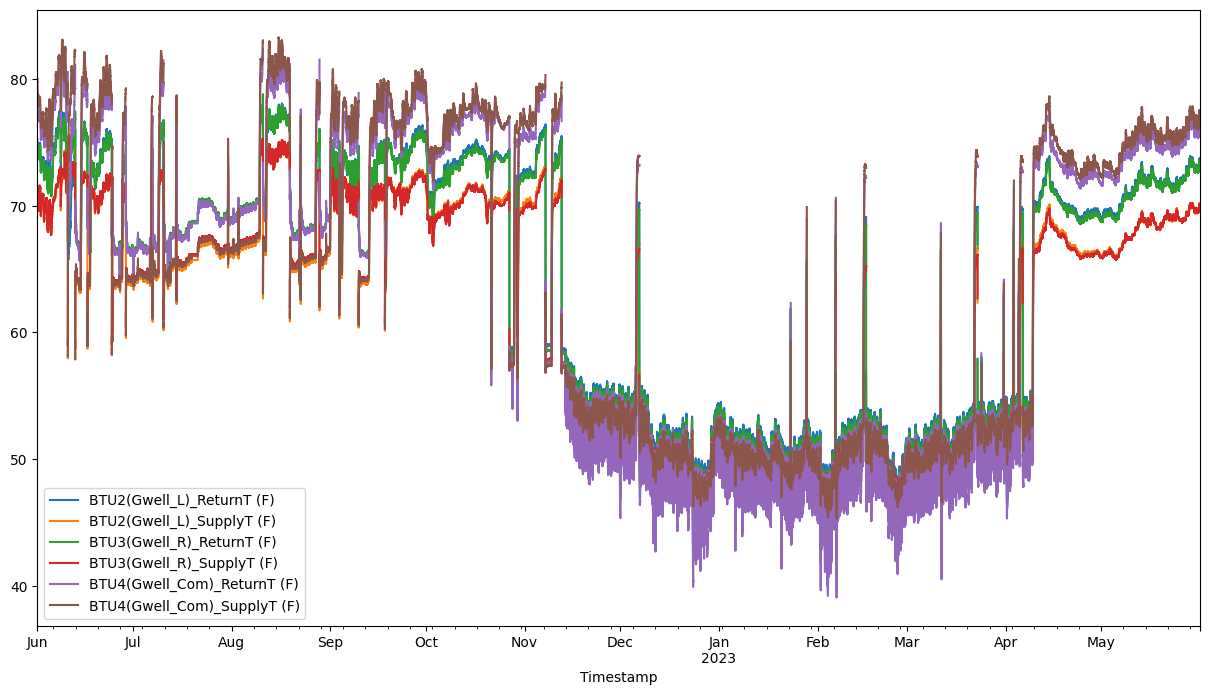

In [16]:
df_with_F.plot(figsize=(15, 8))

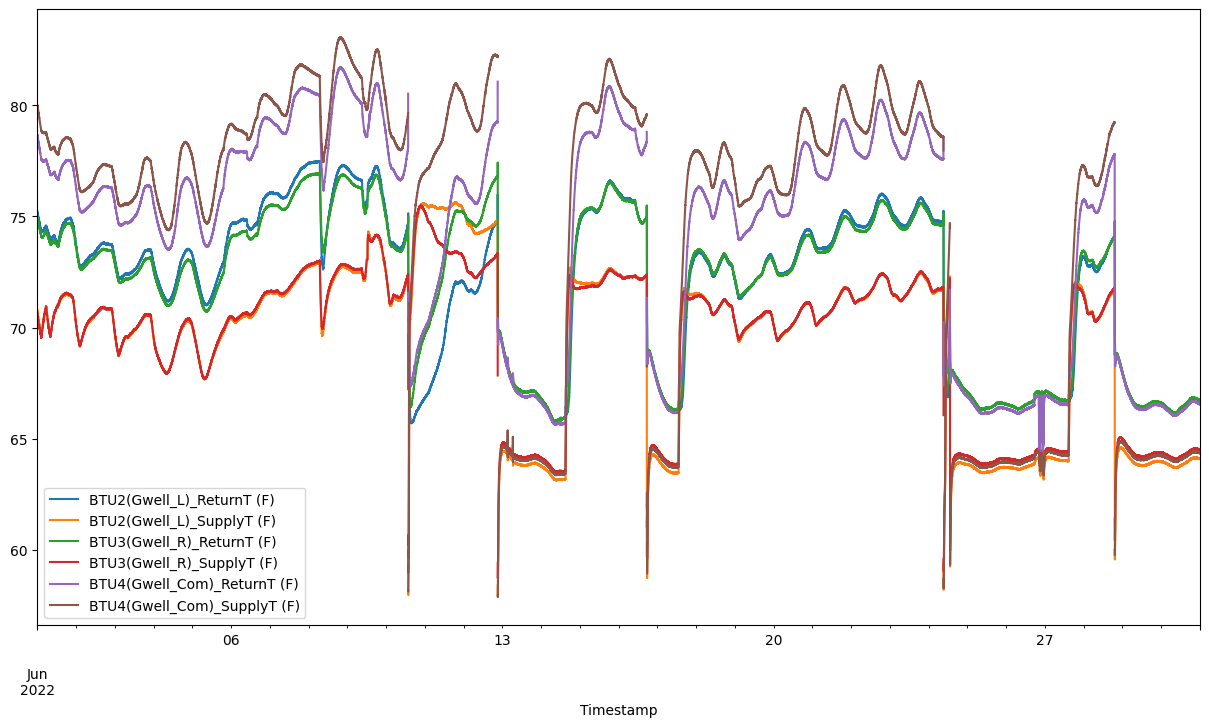

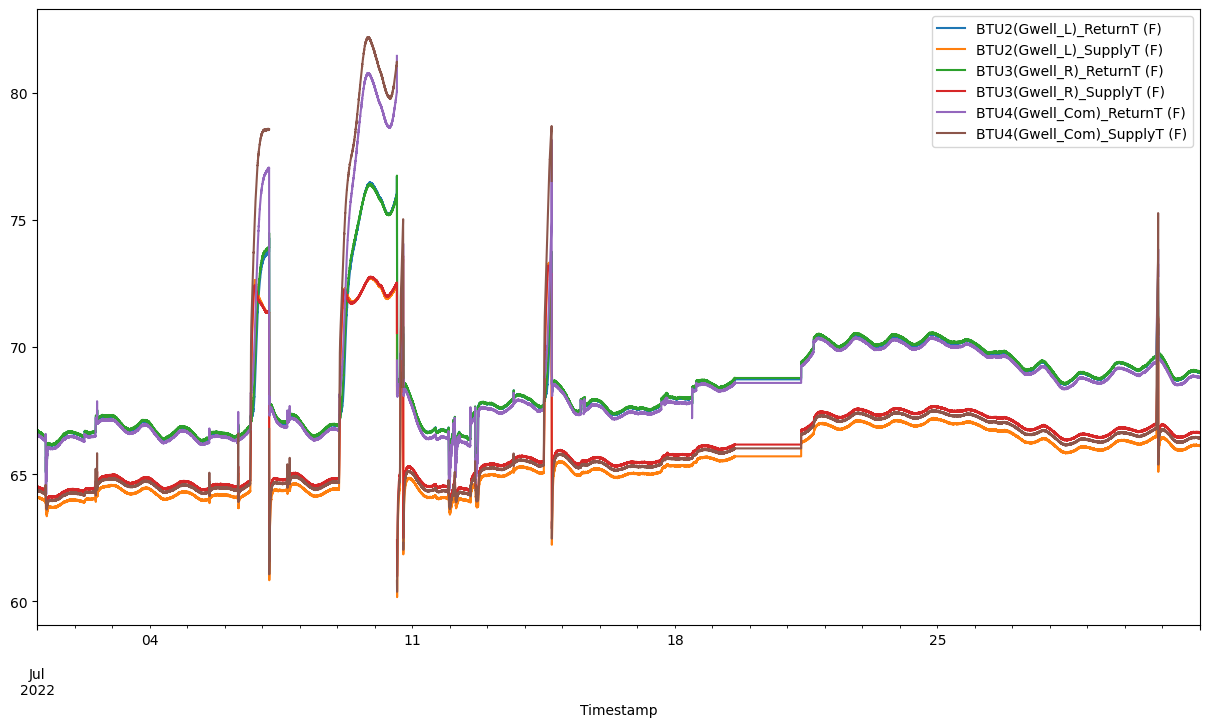

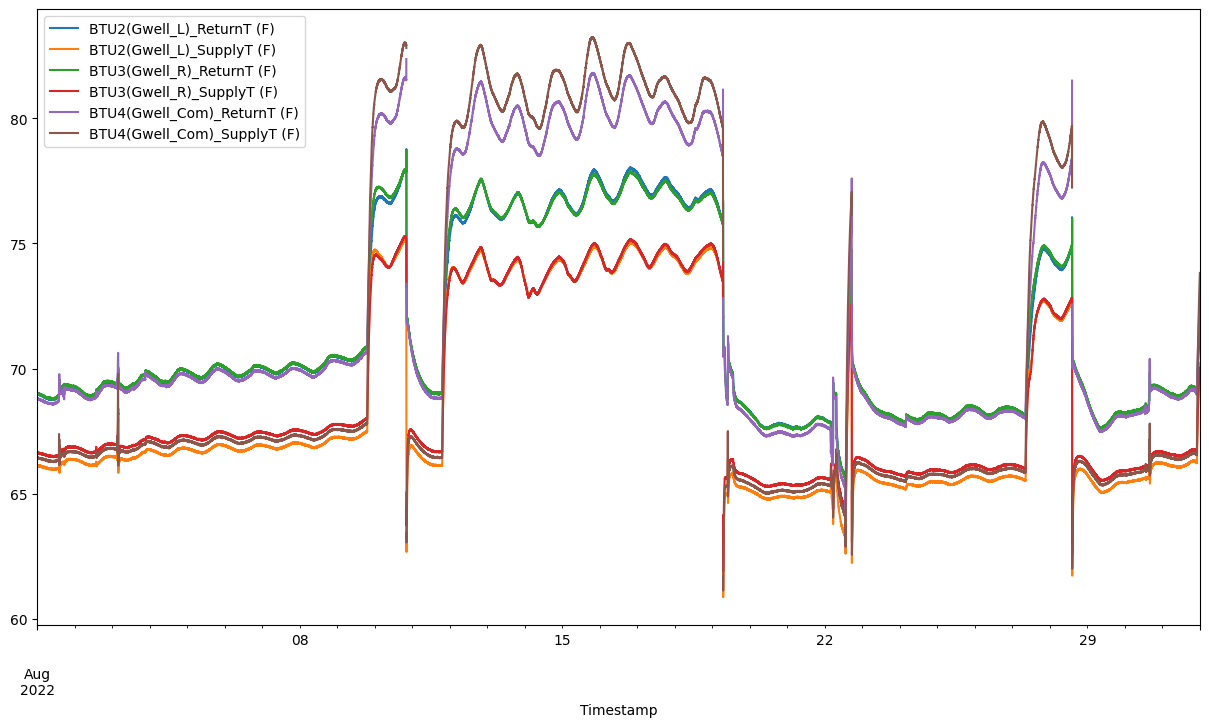

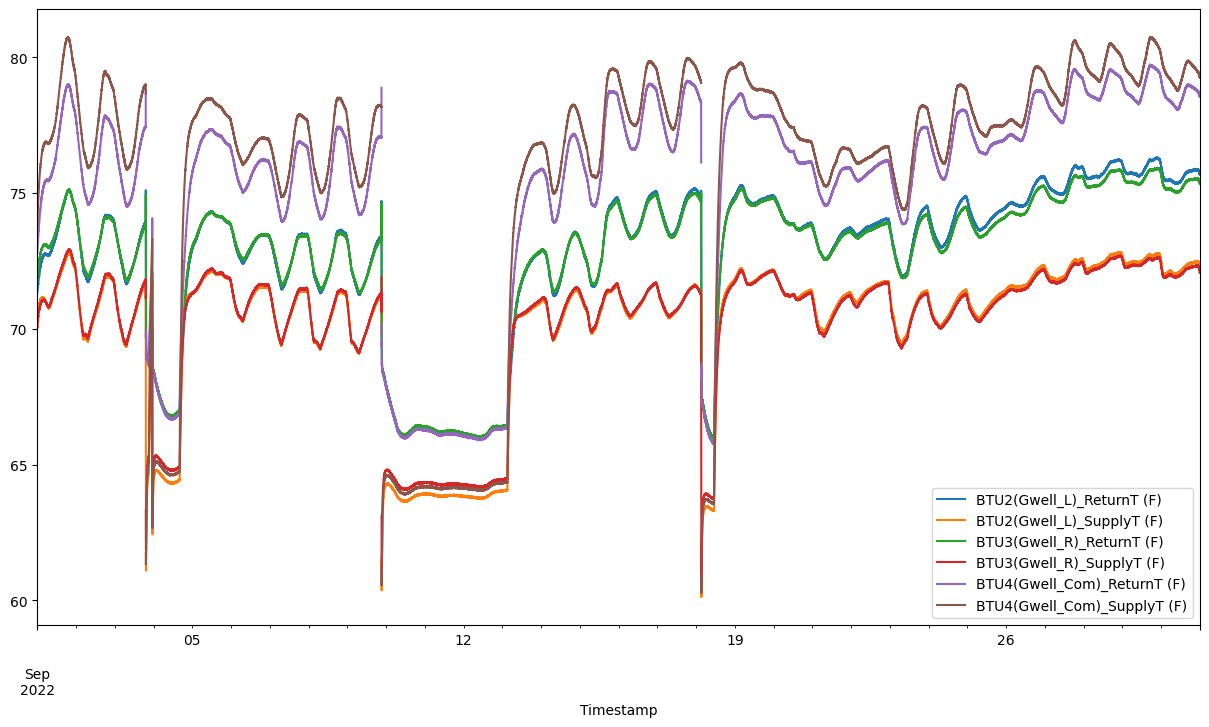

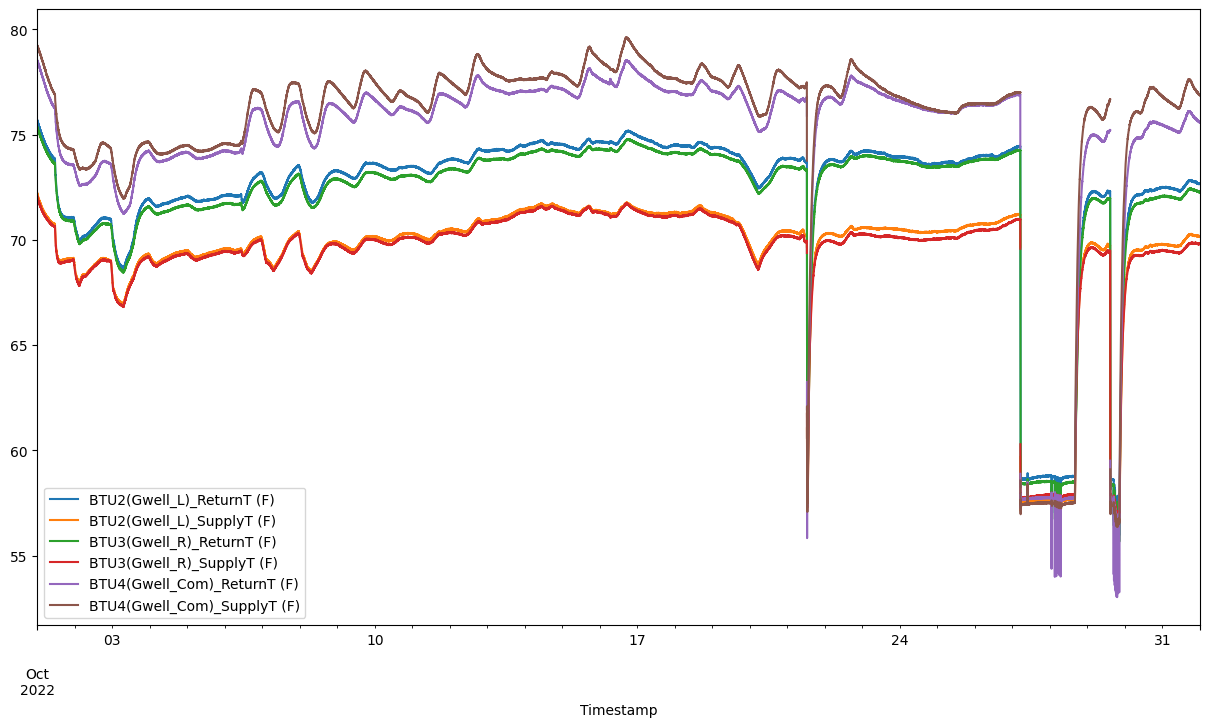

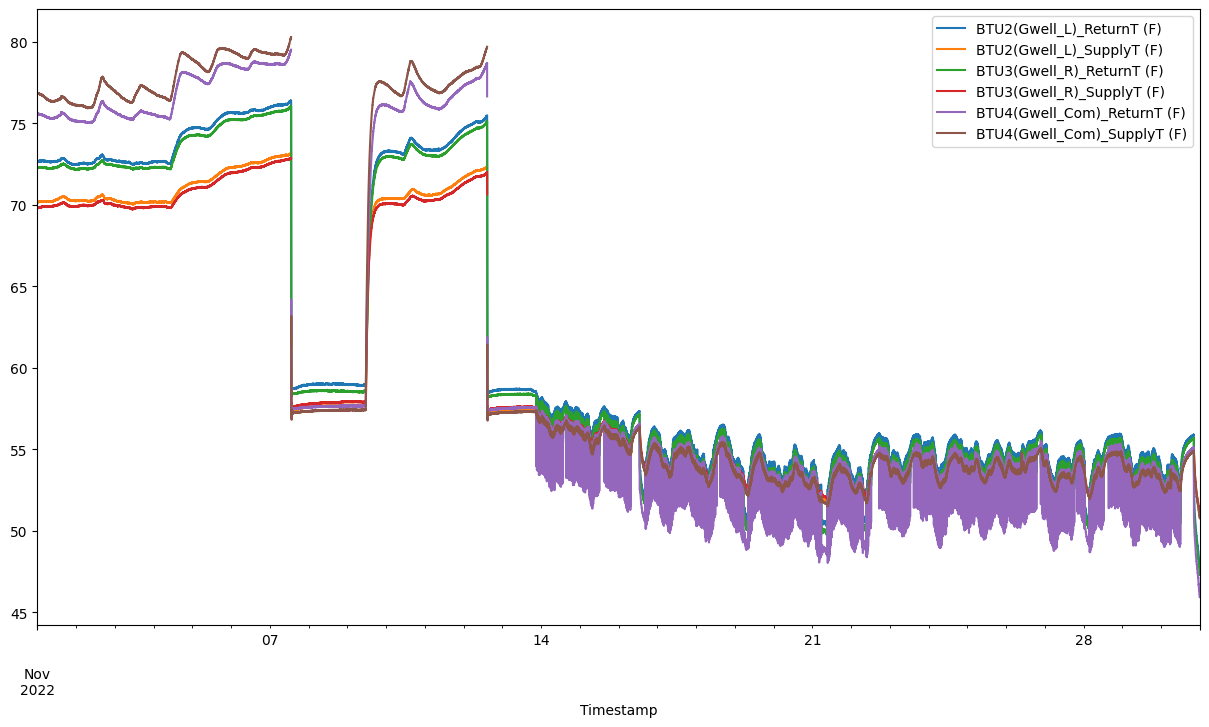

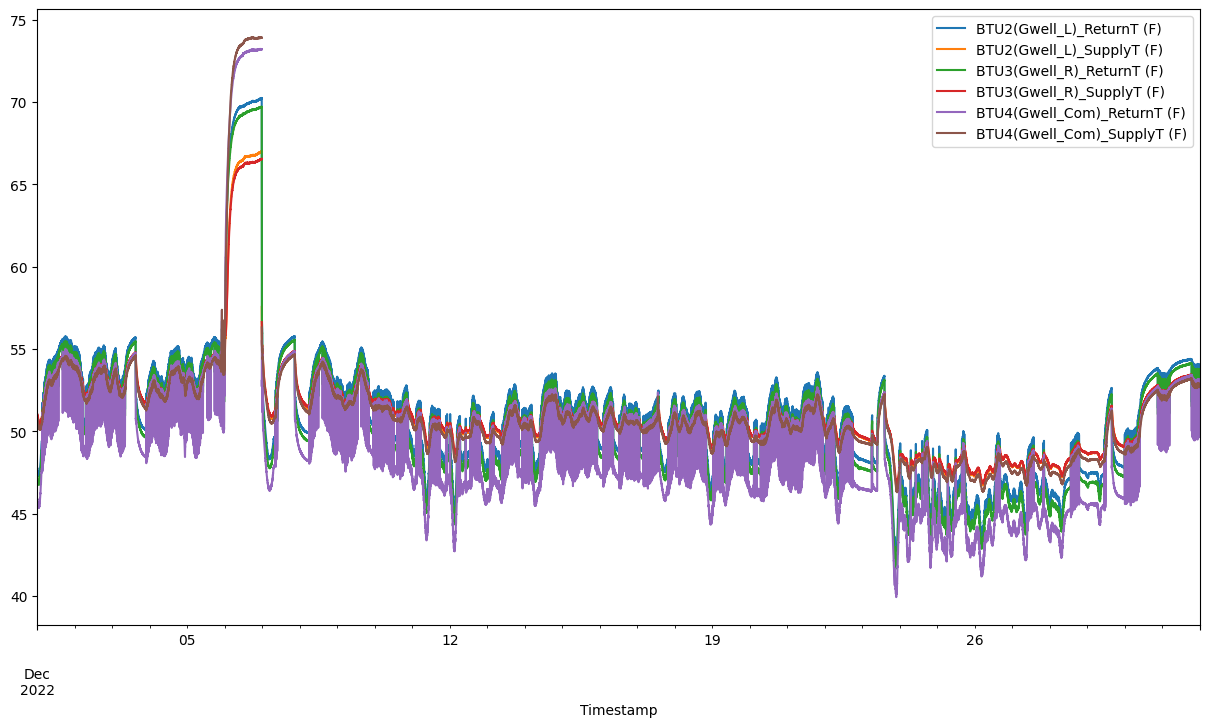

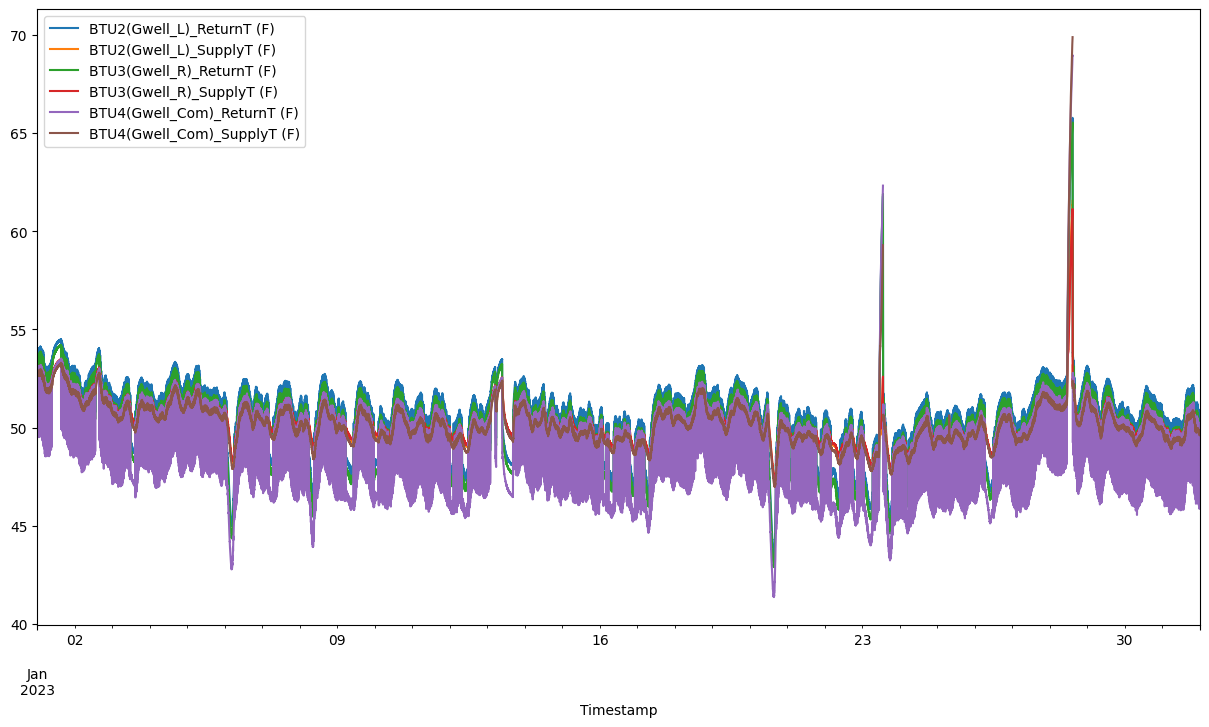

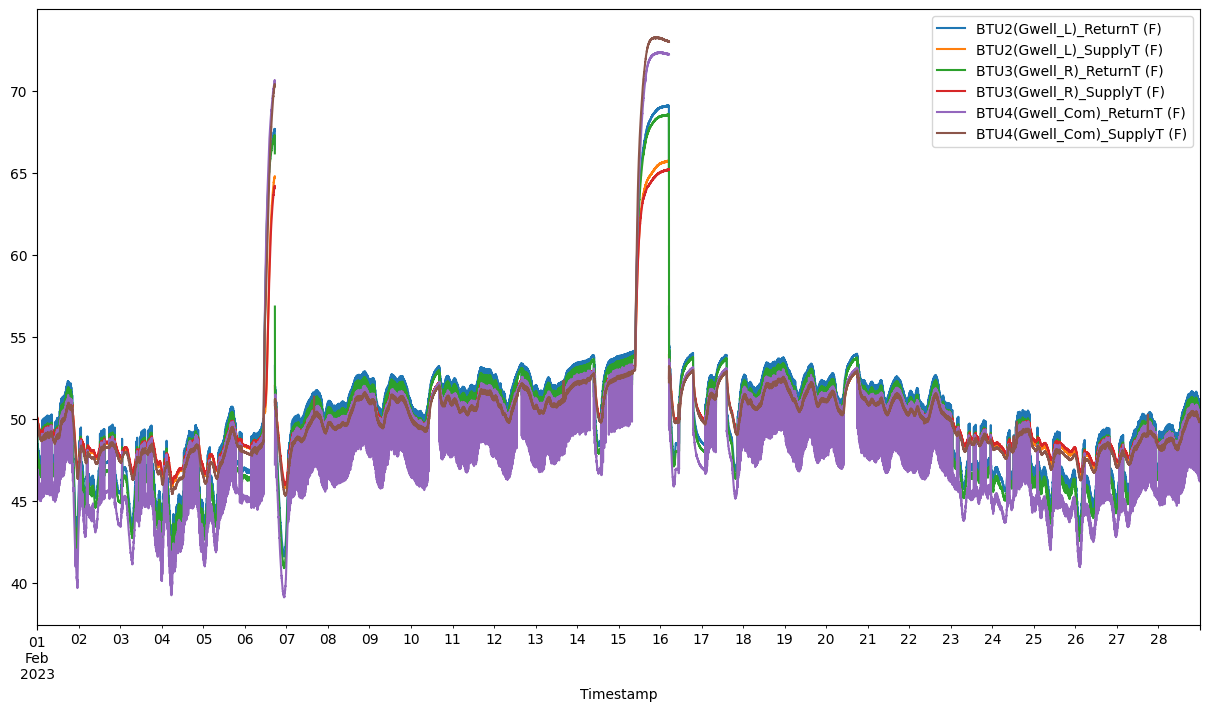

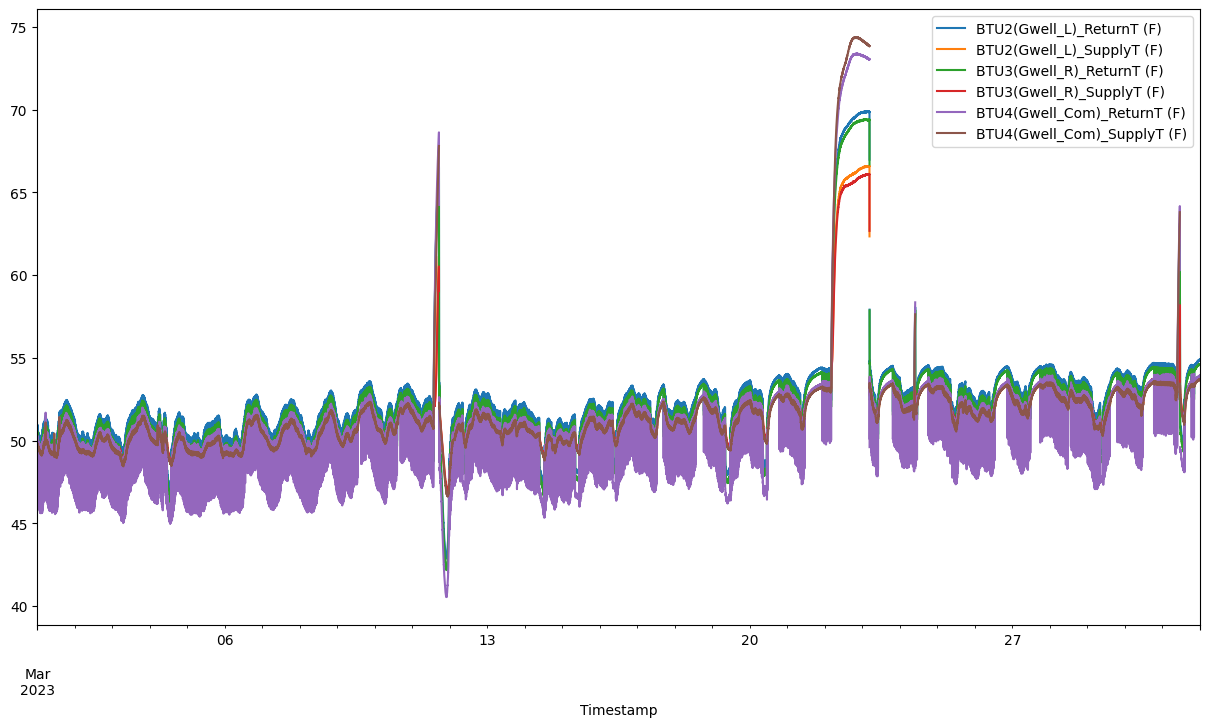

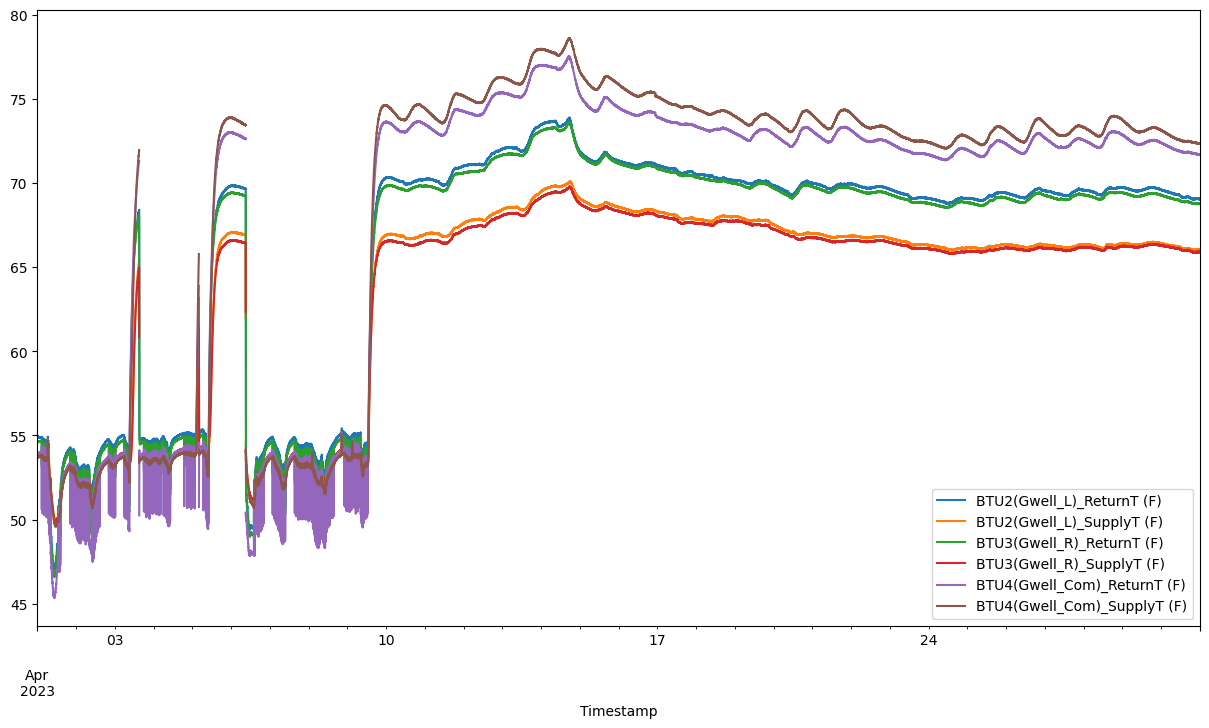

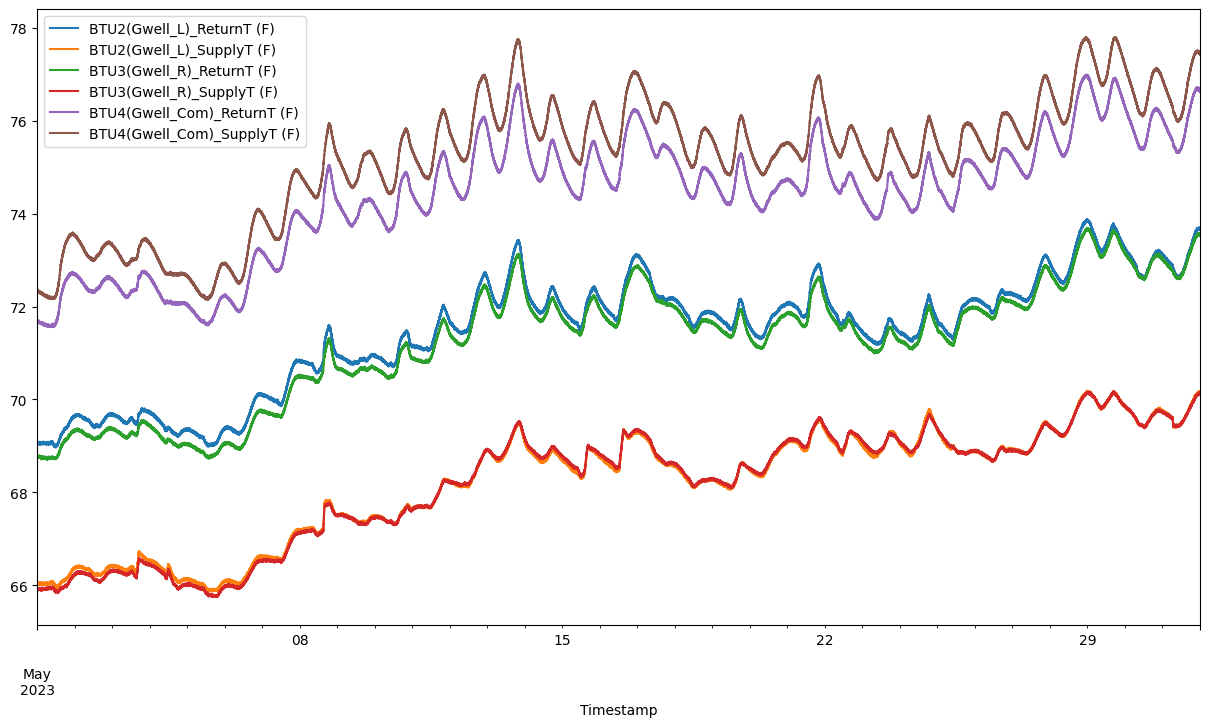

In [17]:
#Then, group by year and week number and apply Mahalanobis distance function
for (year, month), group in df_with_F.groupby([df_with_F.index.year, df_with_F.index.month]):

    group.plot(figsize=(15, 8))
    

Mahalanobis Distance Outlier Removal

In [18]:
def mahalanobis_distance(x, data):
    """Calculate the Mahalanobis distance for each observation in x from the distribution of data"""
    x_minus_mu = x - np.mean(data)
    cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

def remove_outliers(df, columns):
    # Assuming df has a datetime index, group by year and month
    groups = df.groupby([df.index.year, df.index.month])
    
    # Process each group
    for (year, month), group in groups:
        feature_set = group[columns]
        
        # Skip groups with less data points than columns to avoid singular matrix error
        if feature_set.shape[0] <= feature_set.shape[1]:
            continue
        
        # Compute the Mahalanobis distance for each observation
        group['mahalanobis'] = mahalanobis_distance(x=feature_set, data=feature_set)
        # Calculate the p-value for each Mahalanobis distance
        group['p_value'] = 1 - chi2.cdf(group['mahalanobis'], df=feature_set.shape[1])
        
        # Choose a significance level
        significance_level = 0.05
        # Identify outliers
        outliers = group['p_value'] < significance_level
        # Set outliers to NaN
        df.loc[group[outliers].index, columns] = np.nan
    
    # Drop columns for Mahalanobis distance and p-value if they exist
    df.drop(columns=['mahalanobis', 'p_value'], errors='ignore', inplace=True)
    
    return df

# Define subsets for each zone (based on return or supply)
Zone_Temp_base = ['BTU2(Gwell_L)_ReturnT (F)', 'BTU3(Gwell_R)_ReturnT (F)','BTU4(Gwell_Com)_ReturnT (F)']
Zone_Temp_fir = ['BTU2(Gwell_L)_SupplyT (F)', 'BTU3(Gwell_R)_SupplyT (F)','BTU4(Gwell_Com)_SupplyT (F)']


In [19]:
df_with_F.columns.values

array(['BTU2(Gwell_L)_ReturnT (F)', 'BTU2(Gwell_L)_SupplyT (F)',
       'BTU3(Gwell_R)_ReturnT (F)', 'BTU3(Gwell_R)_SupplyT (F)',
       'BTU4(Gwell_Com)_ReturnT (F)', 'BTU4(Gwell_Com)_SupplyT (F)'],
      dtype=object)

<Axes: xlabel='Timestamp'>

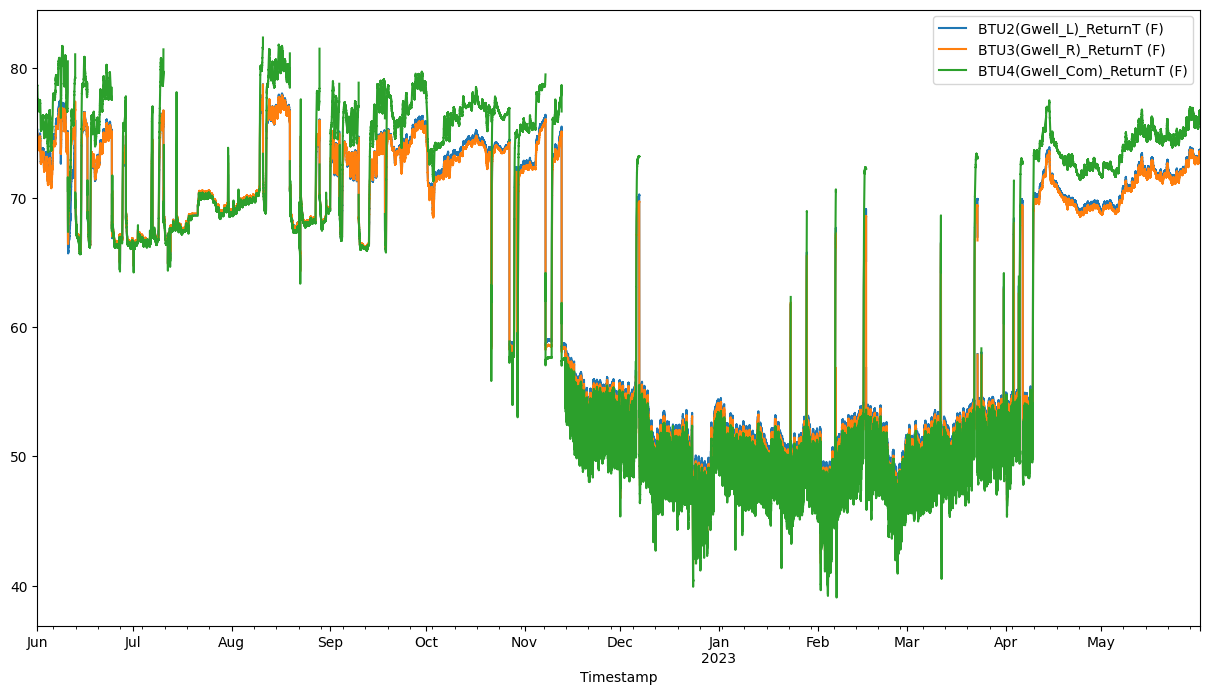

In [20]:
df_with_F[Zone_Temp_base].plot(figsize=(15, 8))

<Axes: xlabel='Timestamp'>

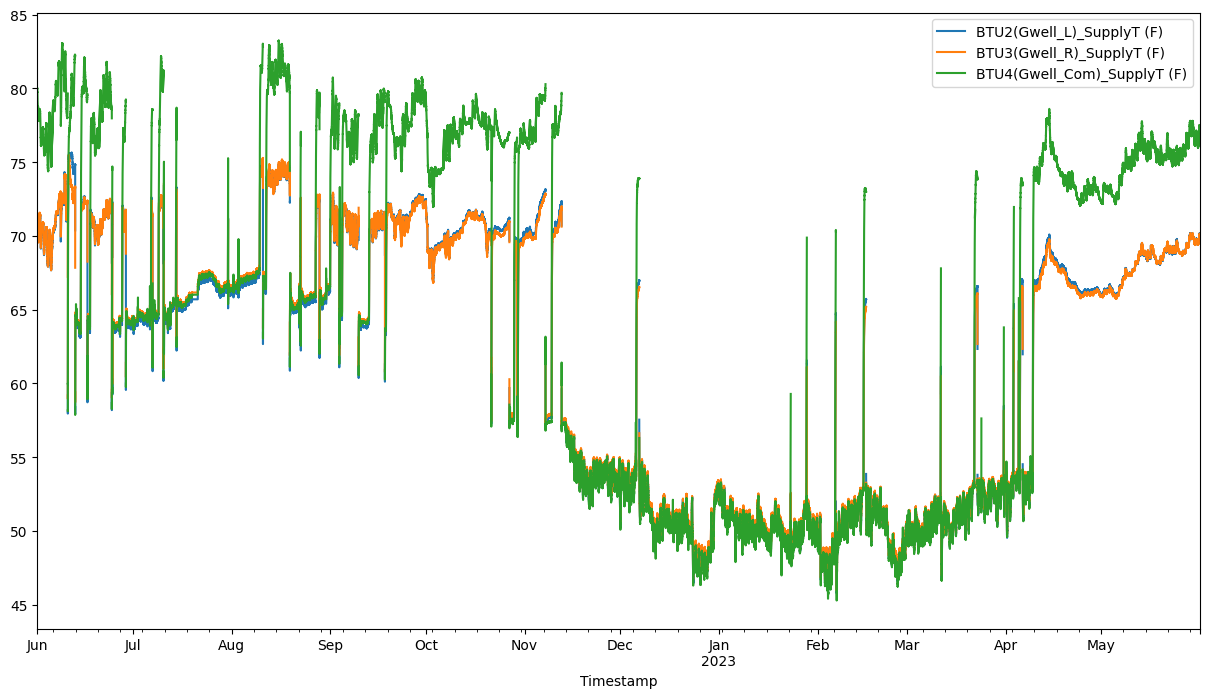

In [21]:
df_with_F[Zone_Temp_fir].plot(figsize=(15, 8))

<Axes: xlabel='Timestamp'>

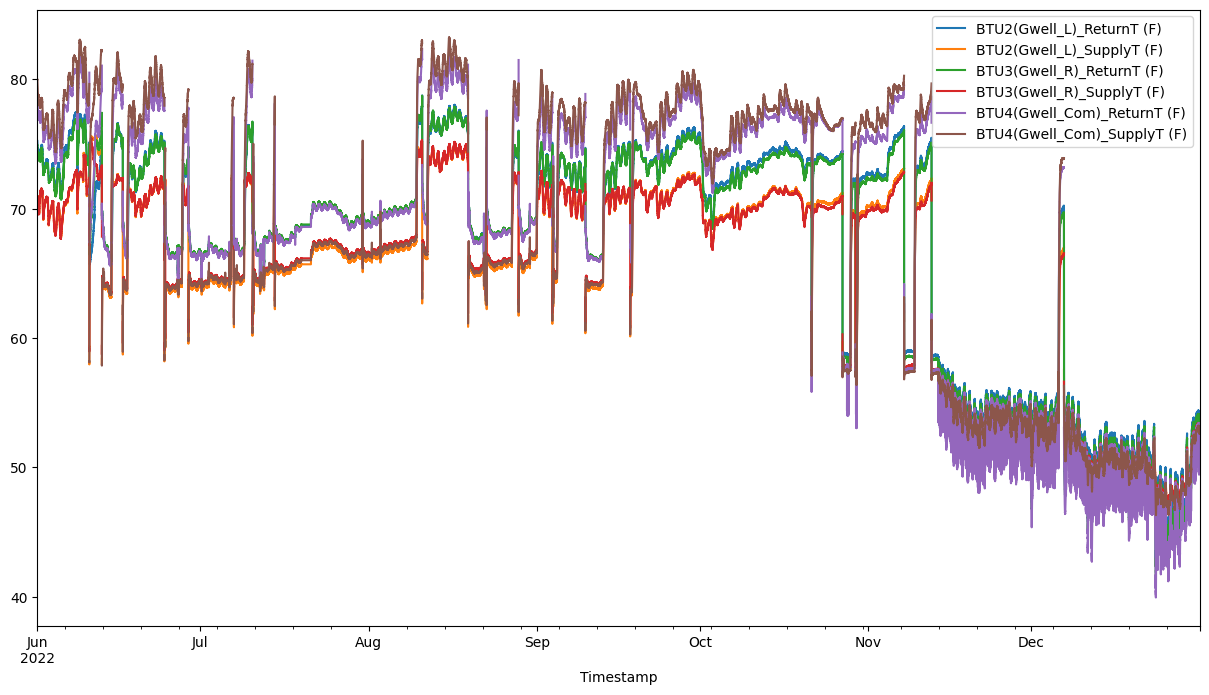

In [22]:
df_with_F1 = df_with_F[: "2022-12-31"]

df_with_F1.plot(figsize=(15, 8))

C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\2533731224.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['mahalanobis', 'p_value'], errors='ignore', inplace=True)
C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\2533731224.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['mahalanobis', 'p_value'], errors='ignore', inplace=True)


<Axes: xlabel='Timestamp'>

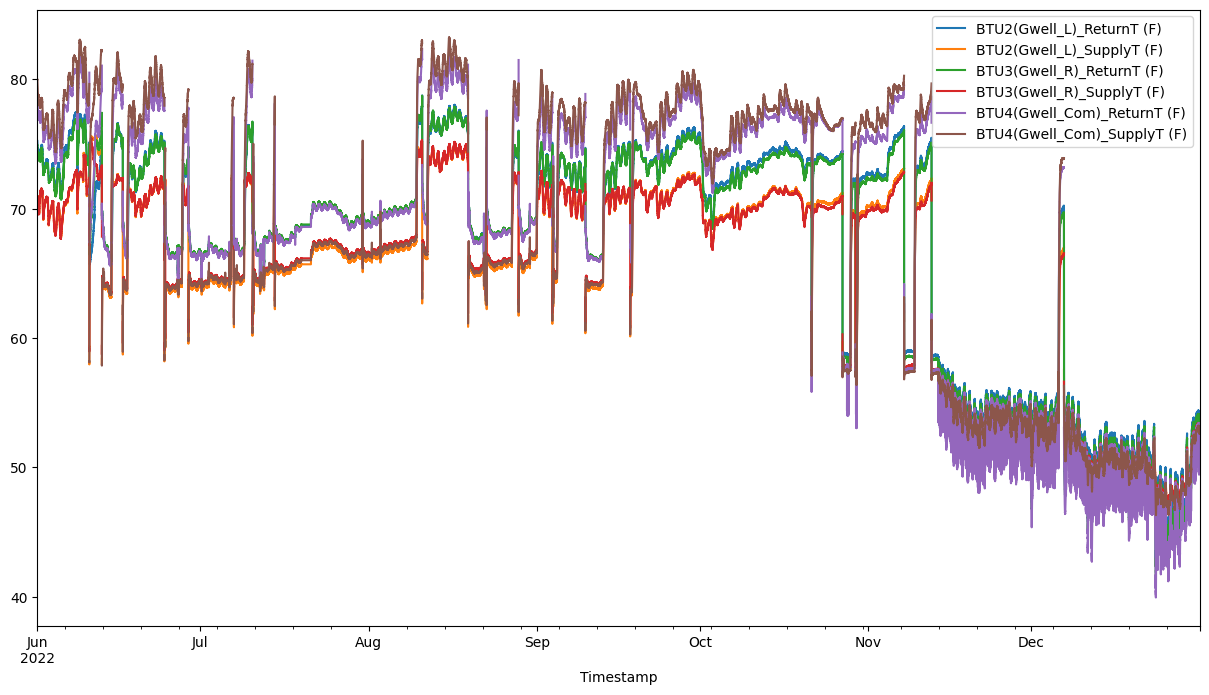

In [23]:
#Use Mahalanobis distance to remove the outliers
df_with_F1 = remove_outliers(df_with_F1, Zone_Temp_base)
df_with_F1 = remove_outliers(df_with_F1, Zone_Temp_fir)

df_with_F1.plot(figsize=(15, 8))

<Axes: xlabel='Timestamp'>

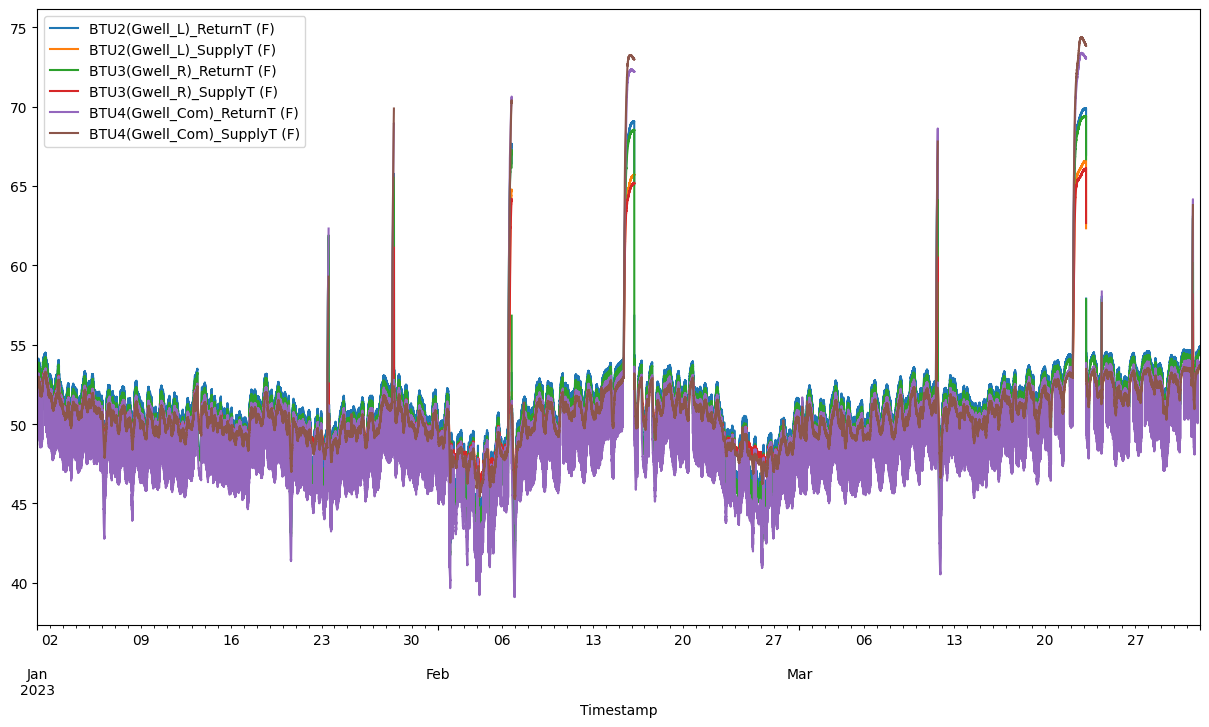

In [24]:
df_with_F2 = df_with_F["2023-01-01": "2023-03-31"]

df_with_F2.plot(figsize=(15, 8))

C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\2533731224.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['mahalanobis', 'p_value'], errors='ignore', inplace=True)
C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\2533731224.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['mahalanobis', 'p_value'], errors='ignore', inplace=True)


<Axes: xlabel='Timestamp'>

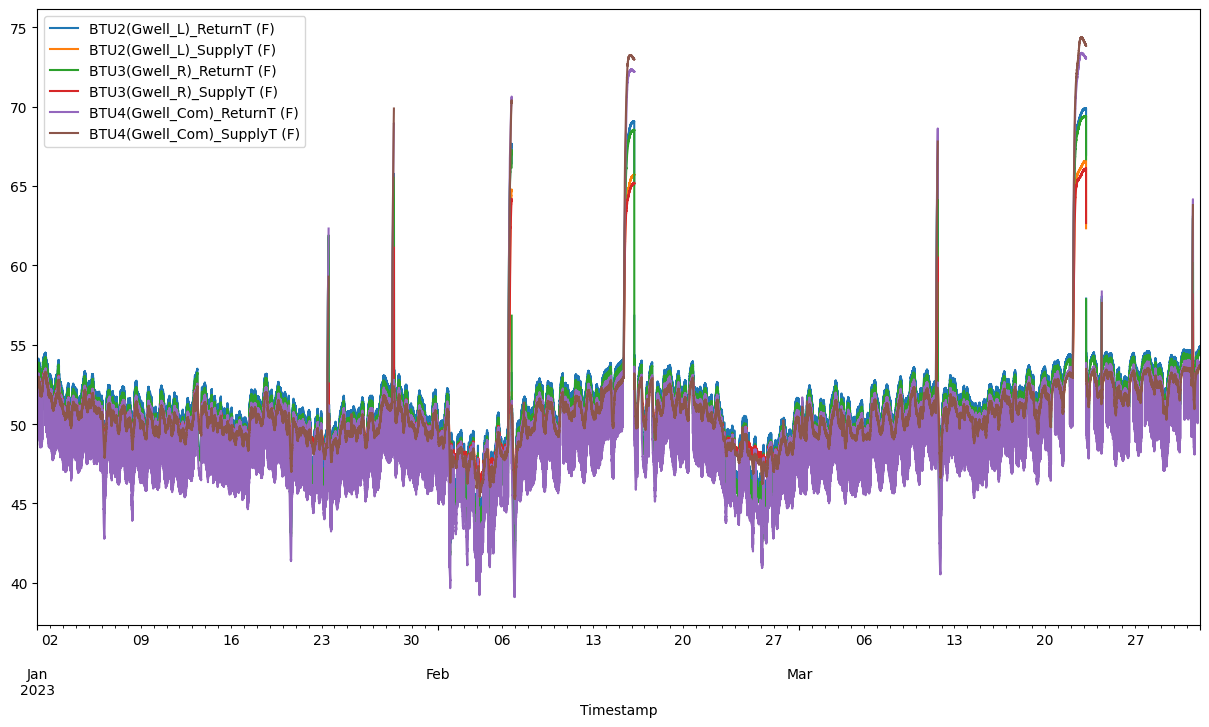

In [25]:
df_with_F2 = remove_outliers(df_with_F2, Zone_Temp_base)
df_with_F2 = remove_outliers(df_with_F2, Zone_Temp_fir)

df_with_F2.plot(figsize=(15, 8))

<Axes: xlabel='Timestamp'>

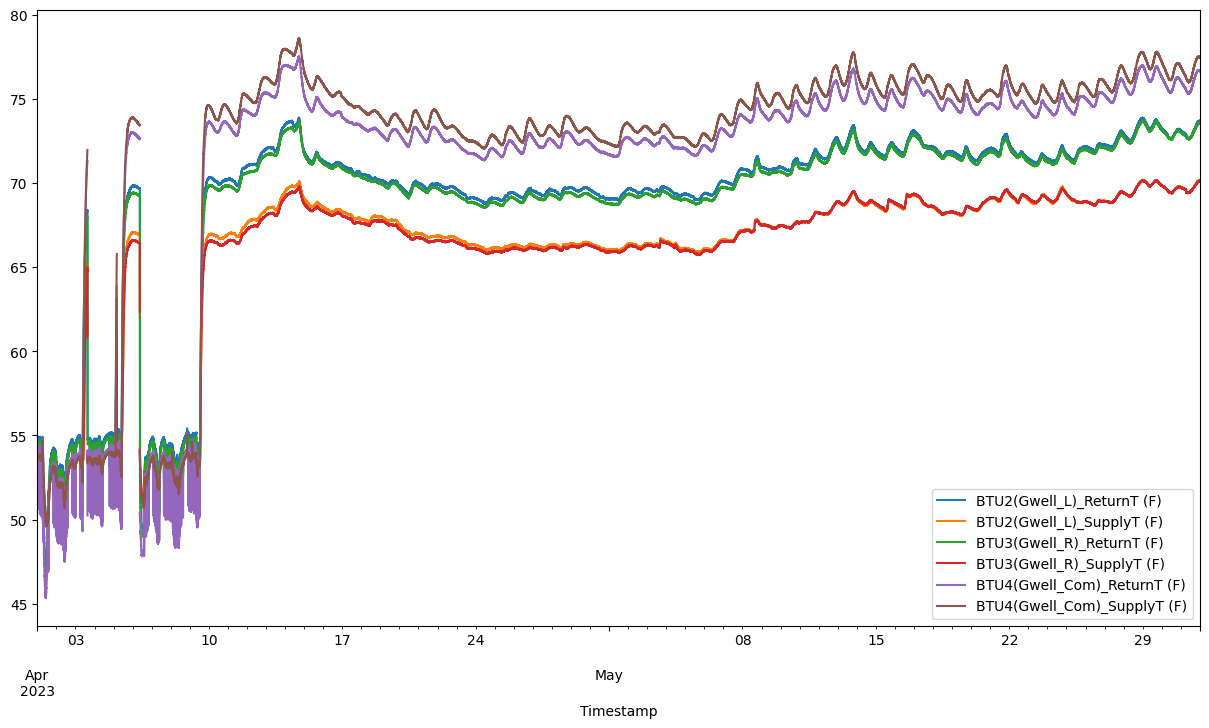

In [26]:
df_with_F3 = df_with_F["2023-04-01": "2023-05-31"]
df_with_F3.plot(figsize=(15, 8))

In [27]:
# Combine all dataframes
combined_df = pd.concat([df_with_F1, df_with_F2, df_with_F3])

In [28]:
# Convert Fahrenheit to Celsius
combined_df = (combined_df - 32) * 5/9
# Renaming columns: Replace 'F' with 'C'
combined_df.columns = [col.replace('F', 'C') for col in combined_df.columns]


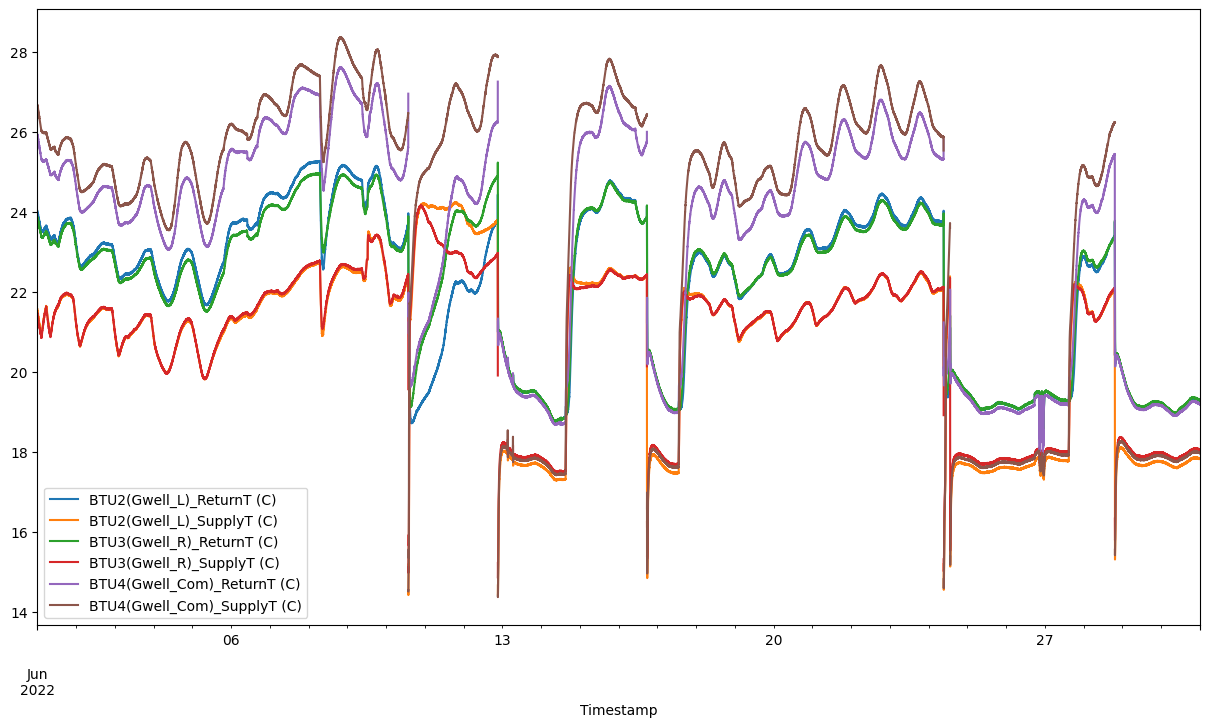

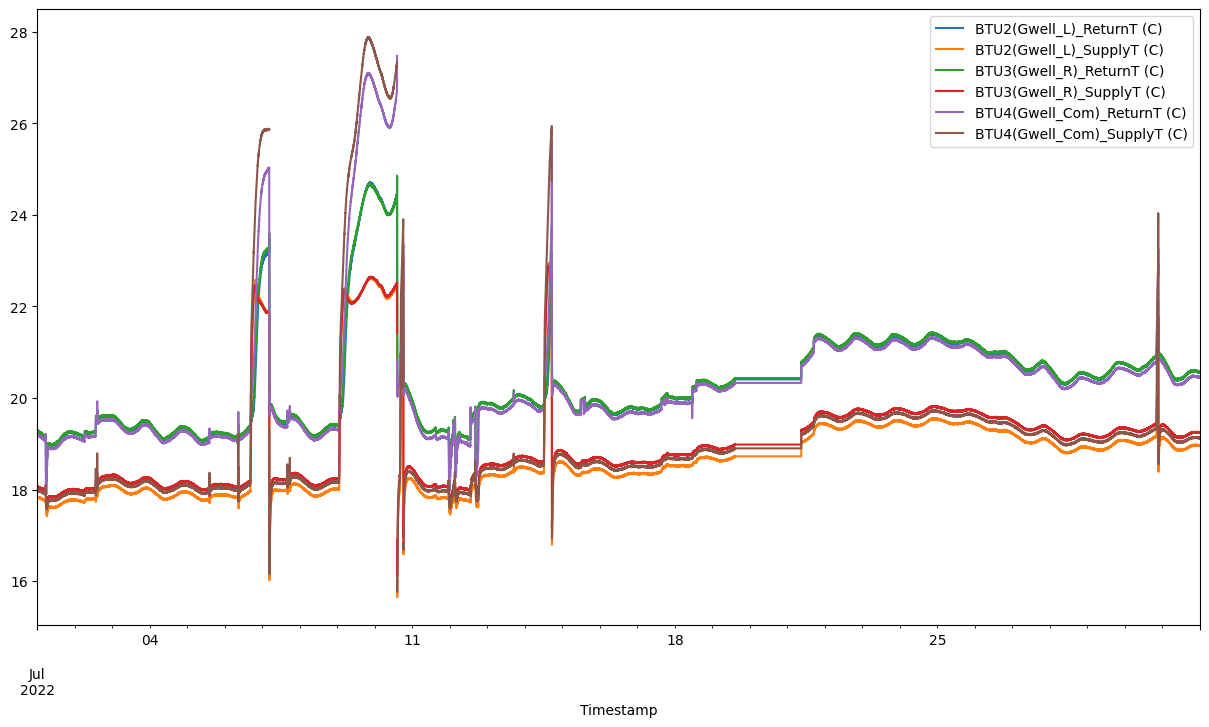

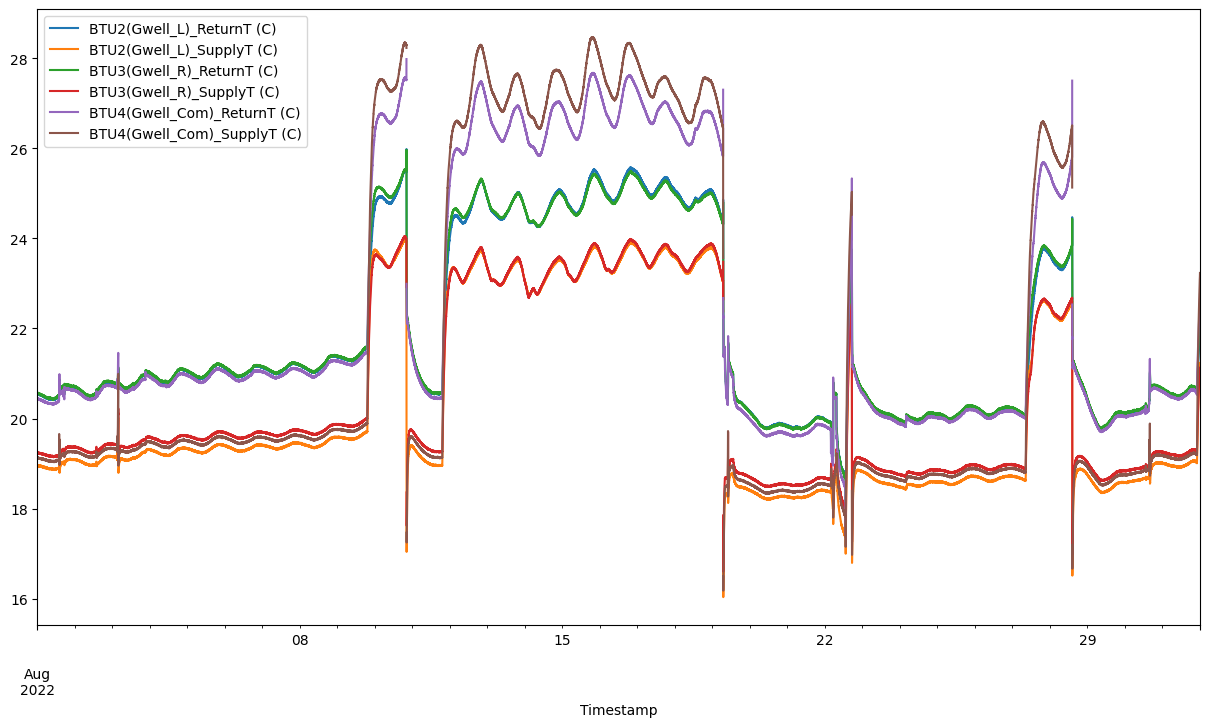

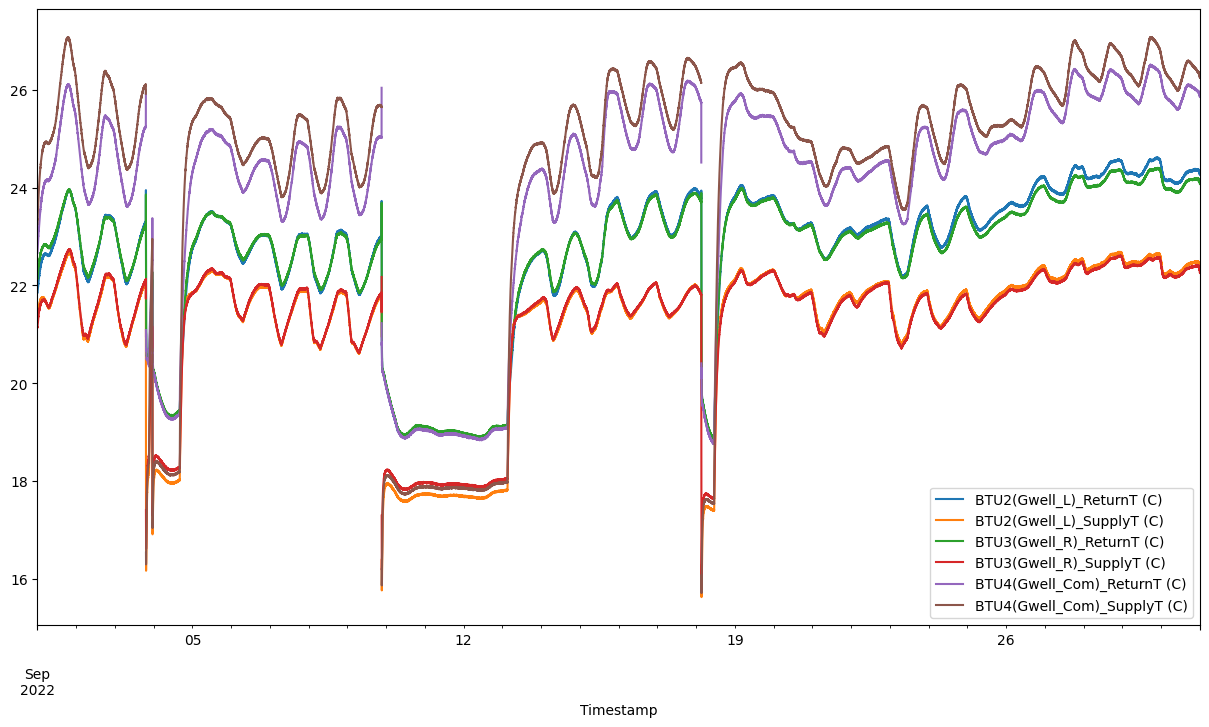

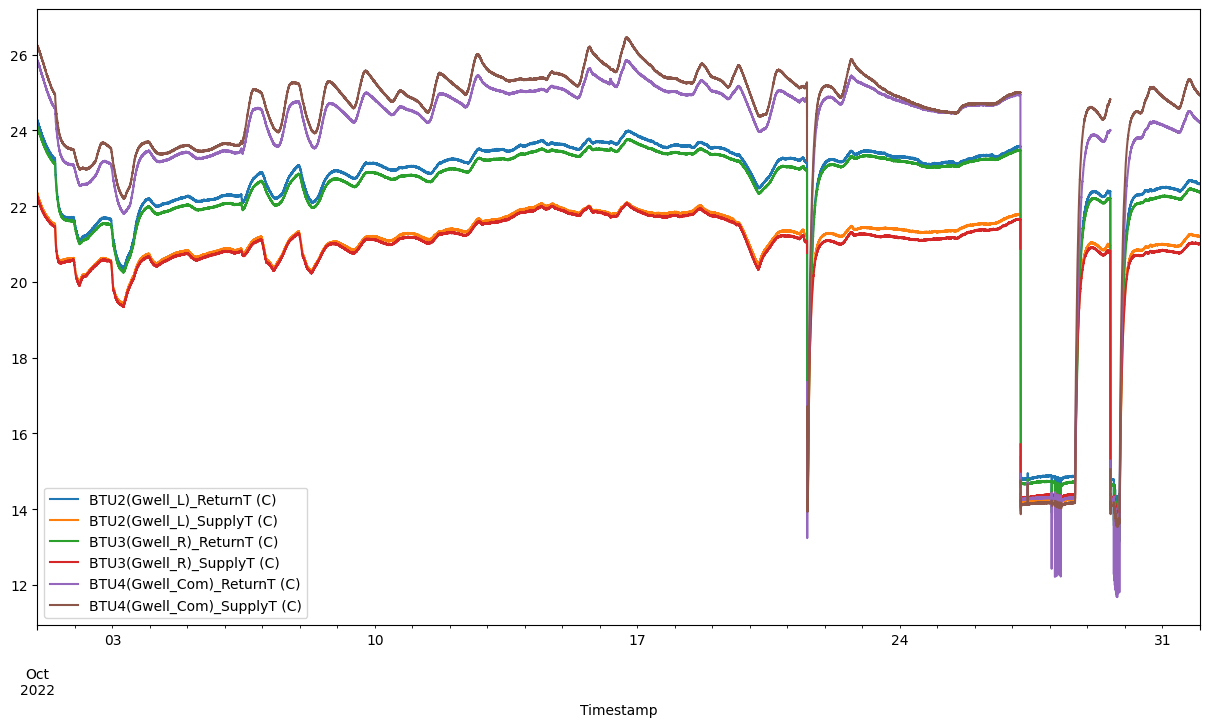

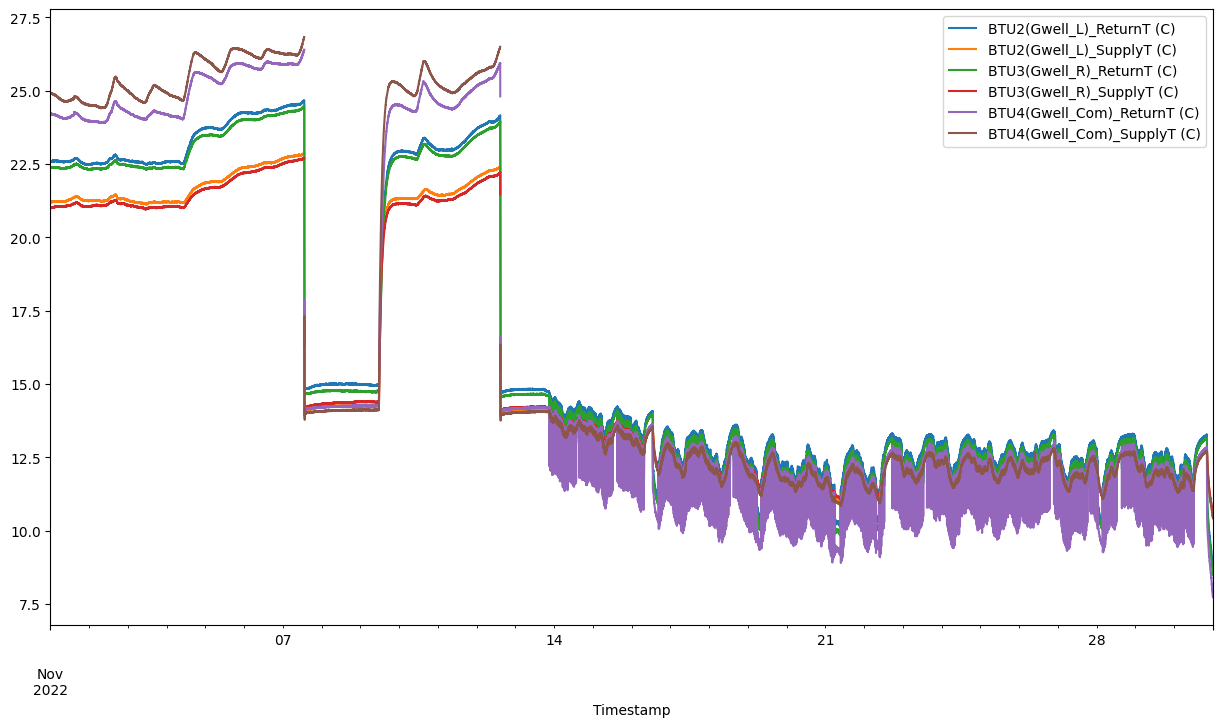

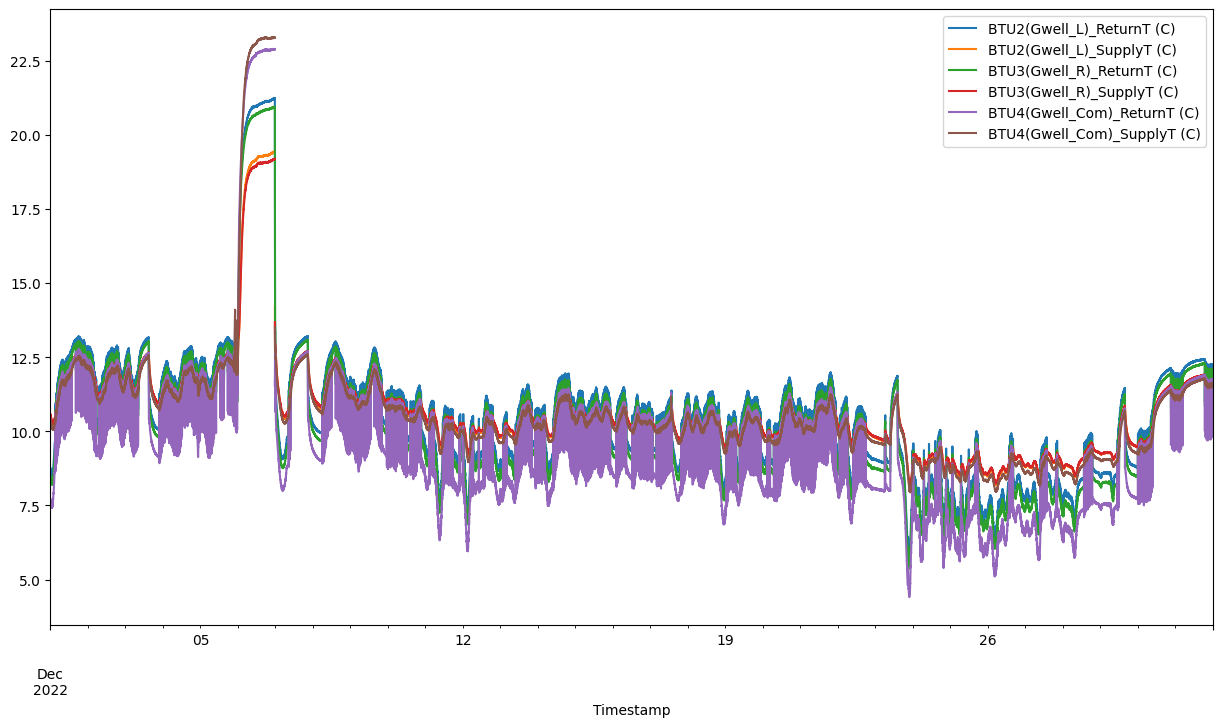

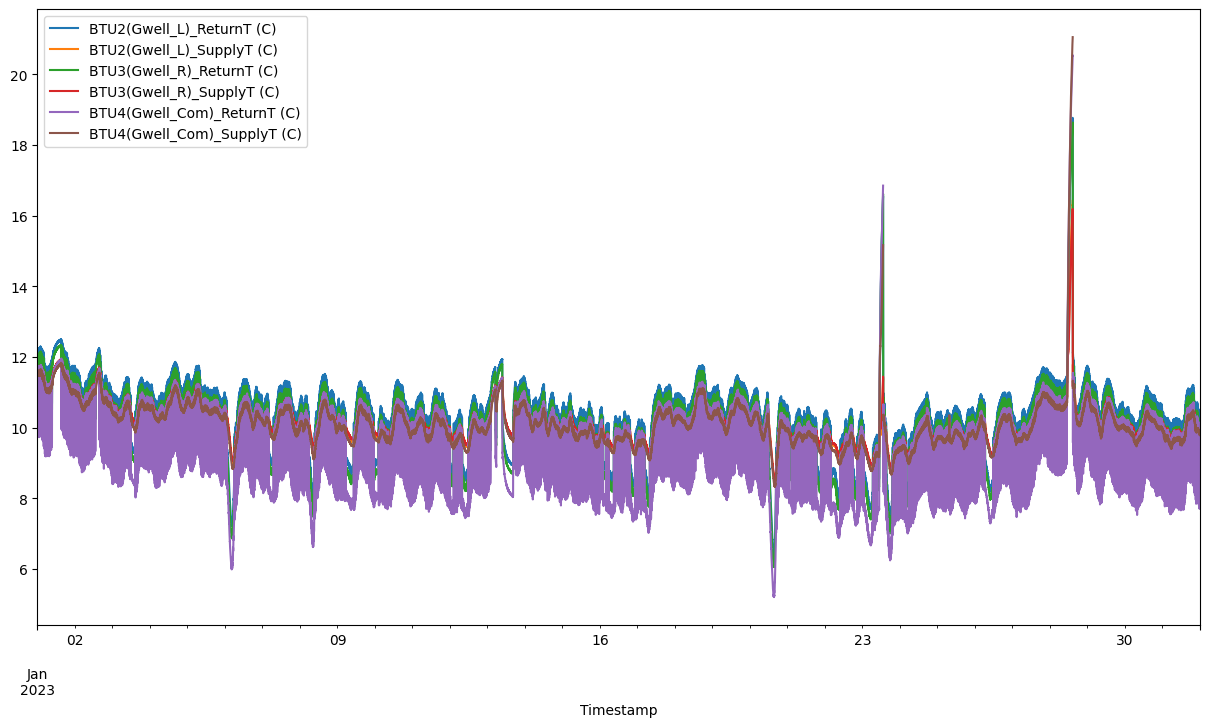

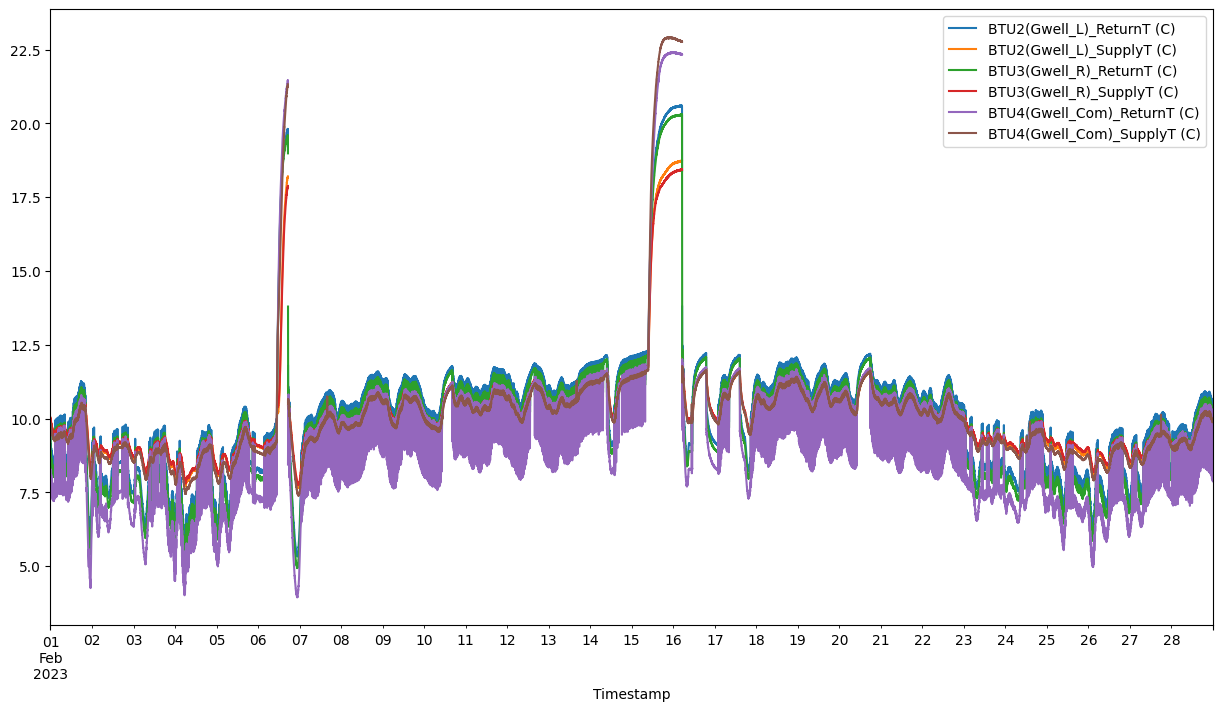

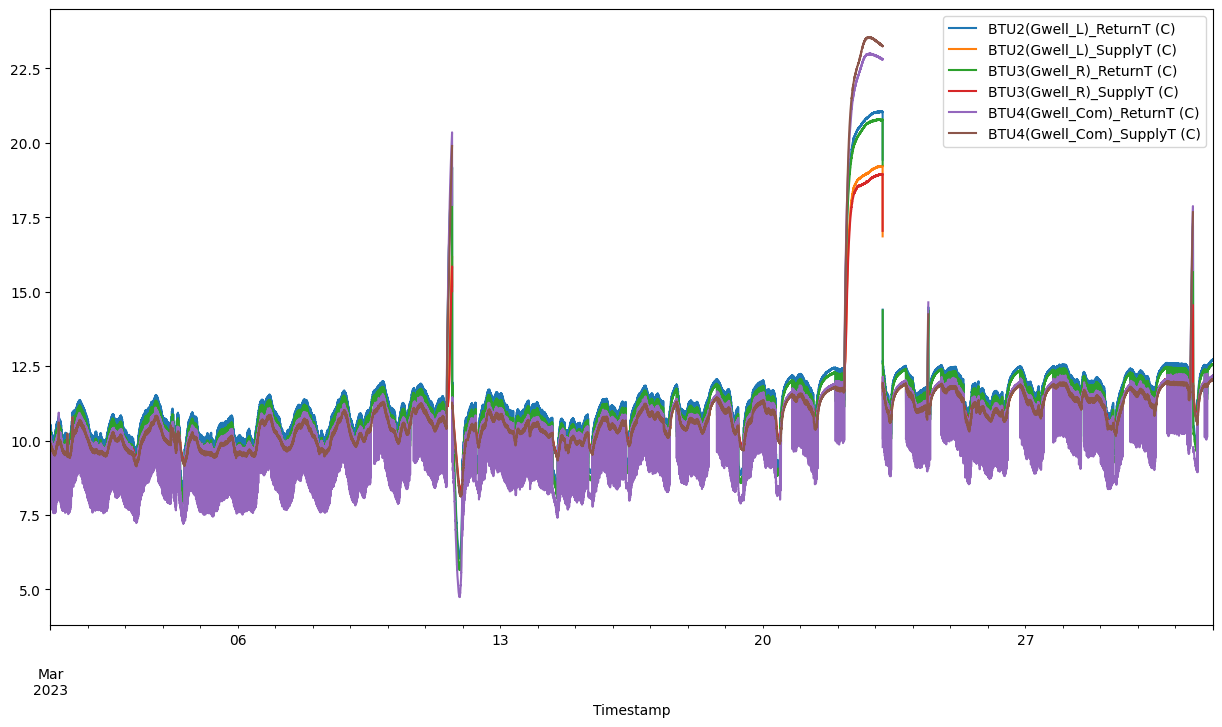

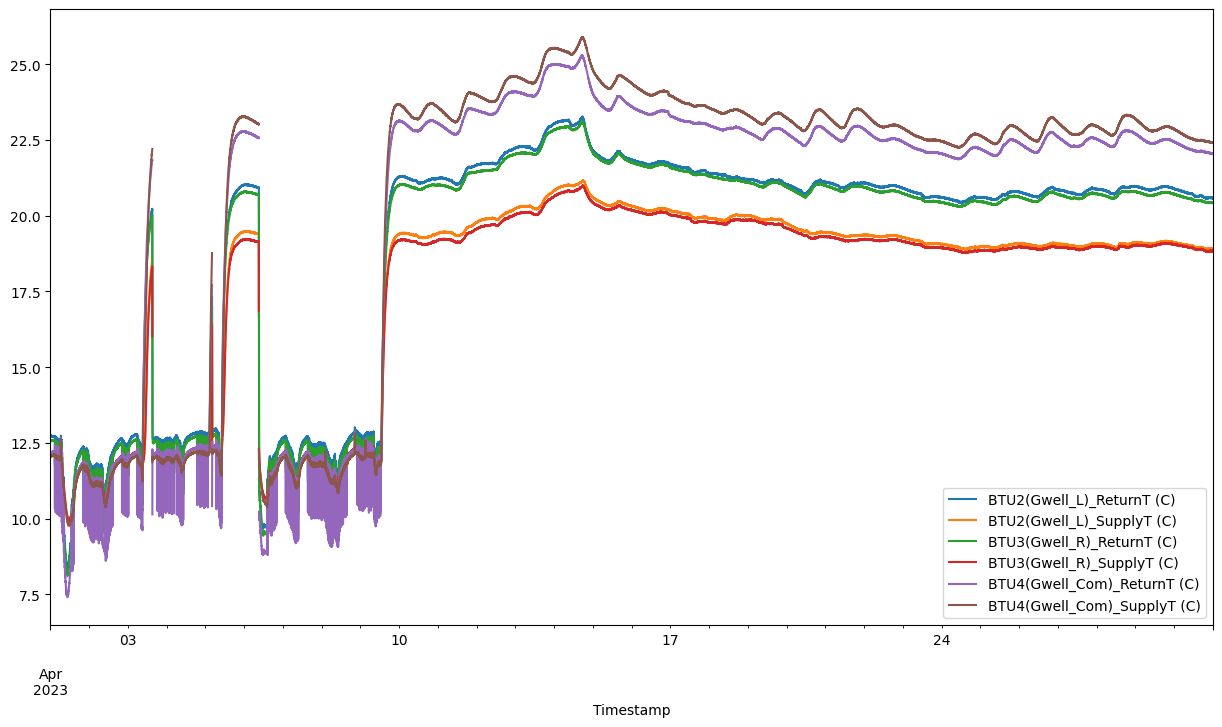

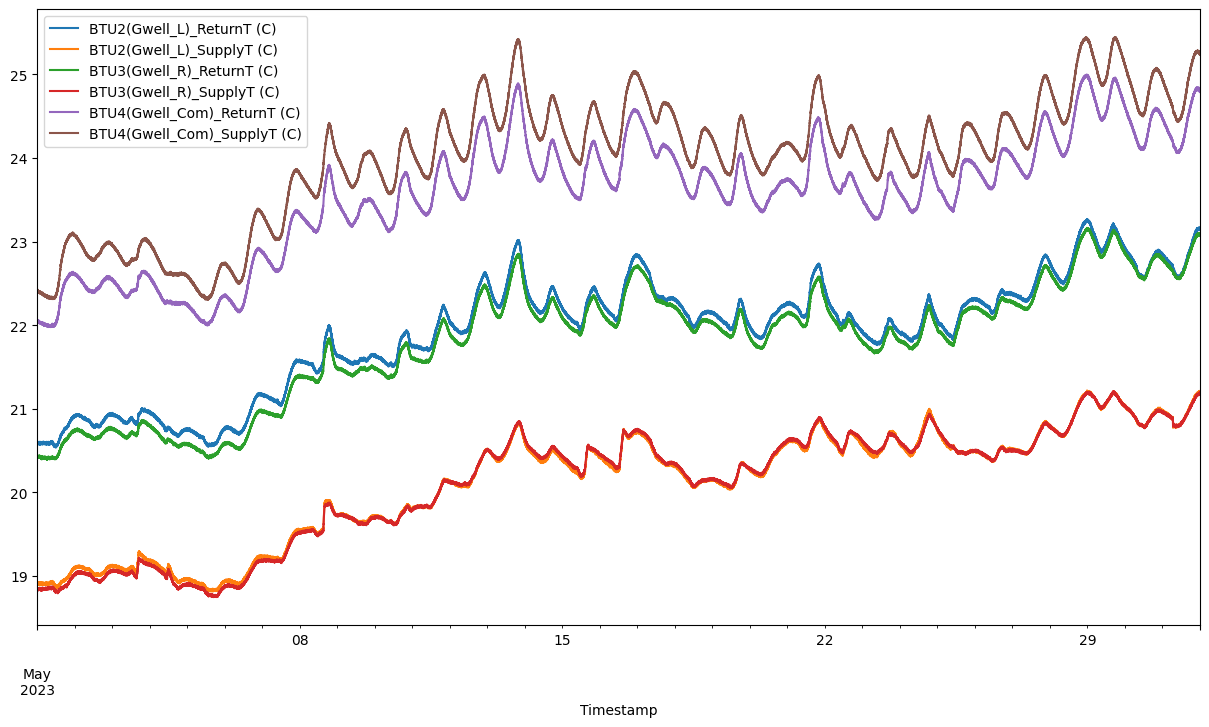

In [29]:
#Group by months, then plot each month for detailed assessment
for (year, month), group in combined_df.groupby([combined_df.index.year, combined_df.index.month]):

    group.plot(figsize=(15, 8))

In [30]:
df_with_F

BTU2(Gwell_L)_ReturnT (F)  \
Timestamp                                              
2022-06-01 00:00:00-04:00                  75.242828   
2022-06-01 00:01:00-04:00                  75.239243   
2022-06-01 00:02:00-04:00                  75.229462   
2022-06-01 00:03:00-04:00                  75.227173   
2022-06-01 00:04:00-04:00                  75.202103   
...                                              ...   
2023-05-31 23:55:00-04:00                  73.670868   
2023-05-31 23:56:00-04:00                  73.673119   
2023-05-31 23:57:00-04:00                  73.662872   
2023-05-31 23:58:00-04:00                  73.670776   
2023-05-31 23:59:00-04:00                  73.667999   

                           BTU2(Gwell_L)_SupplyT (F)  \
Timestamp                                              
2022-06-01 00:00:00-04:00                  70.820366   
2022-06-01 00:01:00-04:00                  70.796852   
2022-06-01 00:02:00-04:00                  70.808212   
2022-06-01 00:03:00-04:00                  70.778770   
2022-06-01 00:04:00-04:00                  70.752434   
...                                              ...   
2023-05-31 23:55:00-04:00                  70.171722   
2023-05-31 23:56:00-04:00                  70.182915   
2023-05-31 23:57:00-04:00                  70.170509   
2023-05-31 23:58:00-04:00                  70.165970   
2023-05-31 23:59:00-04:00                  70.170174   

                           BTU3(Gwell_R)_ReturnT (F)  \
Timestamp                                              
2022-06-01 00:00:00-04:00                  74.955559   
2022-06-01 00:01:00-04:00                  74.963394   
2022-06-01 00:02:00-04:00                  74.962601   
2022-06-01 00:03:00-04:00                  74.947350   
2022-06-01 00:04:00-04:00                  74.954453   
...                                              ...   
2023-05-31 23:55:00-04:00                  73.539406   
2023-05-31 23:56:00-04:00                  73.549744   
2023-05-31 23:57:00-04:00                  73.558548   
2023-05-31 23:58:00-04:00                  73.543999   
2023-05-31 23:59:00-04:00                  73.547234   

                           BTU3(Gwell_R)_SupplyT (F)  \
Timestamp                                              
2022-06-01 00:00:00-04:00                  70.650665   
2022-06-01 00:01:00-04:00                  70.661415   
2022-06-01 00:02:00-04:00                  70.639488   
2022-06-01 00:03:00-04:00                  70.624496   
2022-06-01 00:04:00-04:00                  70.610512   
...                                              ...   
2023-05-31 23:55:00-04:00                  70.128662   
2023-05-31 23:56:00-04:00                  70.135513   
2023-05-31 23:57:00-04:00                  70.133583   
2023-05-31 23:58:00-04:00                  70.149330   
2023-05-31 23:59:00-04:00                  70.133804   

                           BTU4(Gwell_Com)_ReturnT (F)  \
Timestamp                                                
2022-06-01 00:00:00-04:00                    78.685806   
2022-06-01 00:01:00-04:00                    78.700226   
2022-06-01 00:02:00-04:00                    78.676636   
2022-06-01 00:03:00-04:00                    78.647751   
2022-06-01 00:04:00-04:00                    78.653107   
...                                                ...   
2023-05-31 23:55:00-04:00                    76.636429   
2023-05-31 23:56:00-04:00                    76.651848   
2023-05-31 23:57:00-04:00                    76.619476   
2023-05-31 23:58:00-04:00                    76.656403   
2023-05-31 23:59:00-04:00                    76.625656   

                           BTU4(Gwell_Com)_SupplyT (F)  
Timestamp                                               
2022-06-01 00:00:00-04:00                    80.012817  
2022-06-01 00:01:00-04:00                    80.030632  
2022-06-01 00:02:00-04:00                    80.005753  
2022-06-01 00:03:00-04:00                    79.993355  
2022-06-01 00:

Repeated and stuck values removal

In [31]:
# Detecting rows with repeated values
repeated_index = (df_with_F.diff() == 0).all(axis=1)
repeated_rows = df_with_F[repeated_index]

# Now let's get the index of the repeated rows
repeated_rows_index = repeated_rows.index.tolist()
#Replace repeated values with null values
df_with_F[repeated_index] = np.nan

C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\835123473.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_F[repeated_index] = np.nan


In [32]:
df_total = pd.concat([df_with_F, df_without_F], axis=1)

In [33]:
df_total

BTU2(Gwell_L)_ReturnT (F)  \
Timestamp                                              
2022-06-01 00:00:00-04:00                  75.242828   
2022-06-01 00:01:00-04:00                  75.239243   
2022-06-01 00:02:00-04:00                  75.229462   
2022-06-01 00:03:00-04:00                  75.227173   
2022-06-01 00:04:00-04:00                  75.202103   
...                                              ...   
2023-05-31 23:55:00-04:00                  73.670868   
2023-05-31 23:56:00-04:00                  73.673119   
2023-05-31 23:57:00-04:00                  73.662872   
2023-05-31 23:58:00-04:00                  73.670776   
2023-05-31 23:59:00-04:00                  73.667999   

                           BTU2(Gwell_L)_SupplyT (F)  \
Timestamp                                              
2022-06-01 00:00:00-04:00                  70.820366   
2022-06-01 00:01:00-04:00                  70.796852   
2022-06-01 00:02:00-04:00                  70.808212   
2022-06-01 00:03:00-04:00                  70.778770   
2022-06-01 00:04:00-04:00                  70.752434   
...                                              ...   
2023-05-31 23:55:00-04:00                  70.171722   
2023-05-31 23:56:00-04:00                  70.182915   
2023-05-31 23:57:00-04:00                  70.170509   
2023-05-31 23:58:00-04:00                  70.165970   
2023-05-31 23:59:00-04:00                  70.170174   

                           BTU3(Gwell_R)_ReturnT (F)  \
Timestamp                                              
2022-06-01 00:00:00-04:00                  74.955559   
2022-06-01 00:01:00-04:00                  74.963394   
2022-06-01 00:02:00-04:00                  74.962601   
2022-06-01 00:03:00-04:00                  74.947350   
2022-06-01 00:04:00-04:00                  74.954453   
...                                              ...   
2023-05-31 23:55:00-04:00                  73.539406   
2023-05-31 23:56:00-04:00                  73.549744   
2023-05-31 23:57:00-04:00                  73.558548   
2023-05-31 23:58:00-04:00                  73.543999   
2023-05-31 23:59:00-04:00                  73.547234   

                           BTU3(Gwell_R)_SupplyT (F)  \
Timestamp                                              
2022-06-01 00:00:00-04:00                  70.650665   
2022-06-01 00:01:00-04:00                  70.661415   
2022-06-01 00:02:00-04:00                  70.639488   
2022-06-01 00:03:00-04:00                  70.624496   
2022-06-01 00:04:00-04:00                  70.610512   
...                                              ...   
2023-05-31 23:55:00-04:00                  70.128662   
2023-05-31 23:56:00-04:00                  70.135513   
2023-05-31 23:57:00-04:00                  70.133583   
2023-05-31 23:58:00-04:00                  70.149330   
2023-05-31 23:59:00-04:00                  70.133804   

                           BTU4(Gwell_Com)_ReturnT (F)  \
Timestamp                                                
2022-06-01 00:00:00-04:00                    78.685806   
2022-06-01 00:01:00-04:00                    78.700226   
2022-06-01 00:02:00-04:00                    78.676636   
2022-06-01 00:03:00-04:00                    78.647751   
2022-06-01 00:04:00-04:00                    78.653107   
...                                                ...   
2023-05-31 23:55:00-04:00                    76.636429   
2023-05-31 23:56:00-04:00                    76.651848   
2023-05-31 23:57:00-04:00                    76.619476   
2023-05-31 23:58:00-04:00                    76.656403   
2023-05-31 23:59:00-04:00                    76.625656   

                           BTU4(Gwell_Com)_SupplyT (F)  \
Timestamp                                                
2022-06-01 00:00:00-04:00                    80.012817   
2022-06-01 00:01:00-04:00                    80.030632   
2022-06-01 00:02:00-04:00                    80.005753   
2022-06-01 00:03:00-04:00                    79.993355   
2022-06-

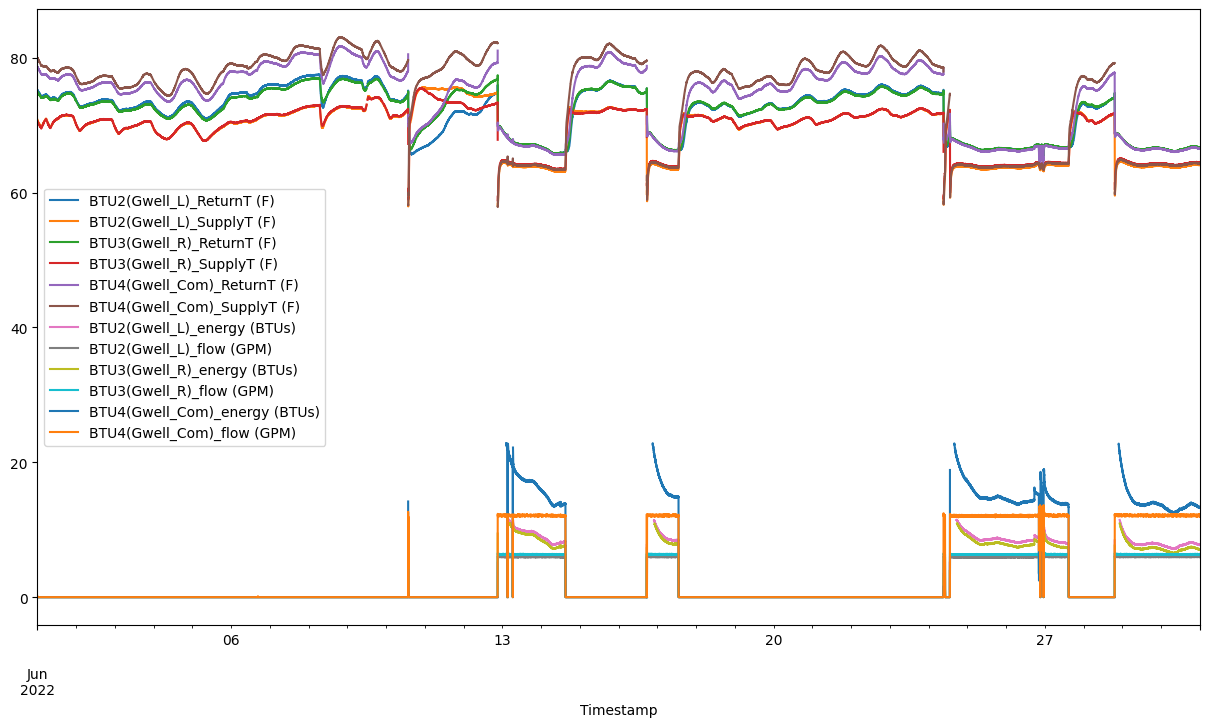

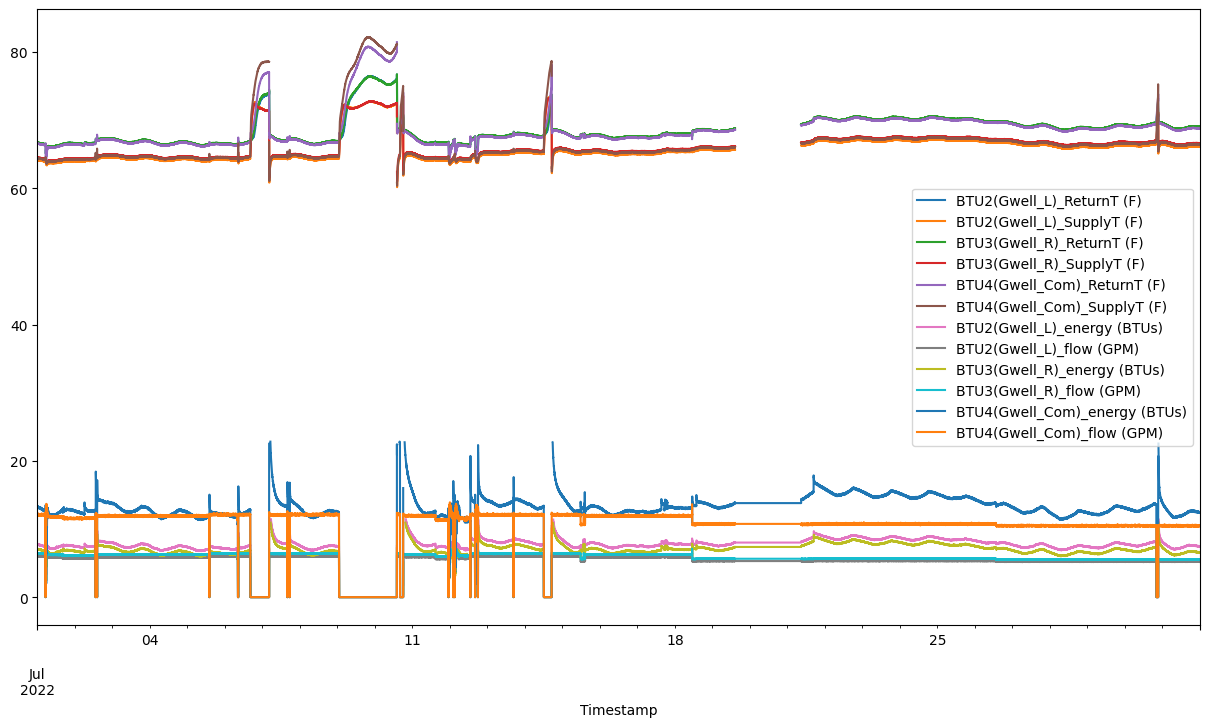

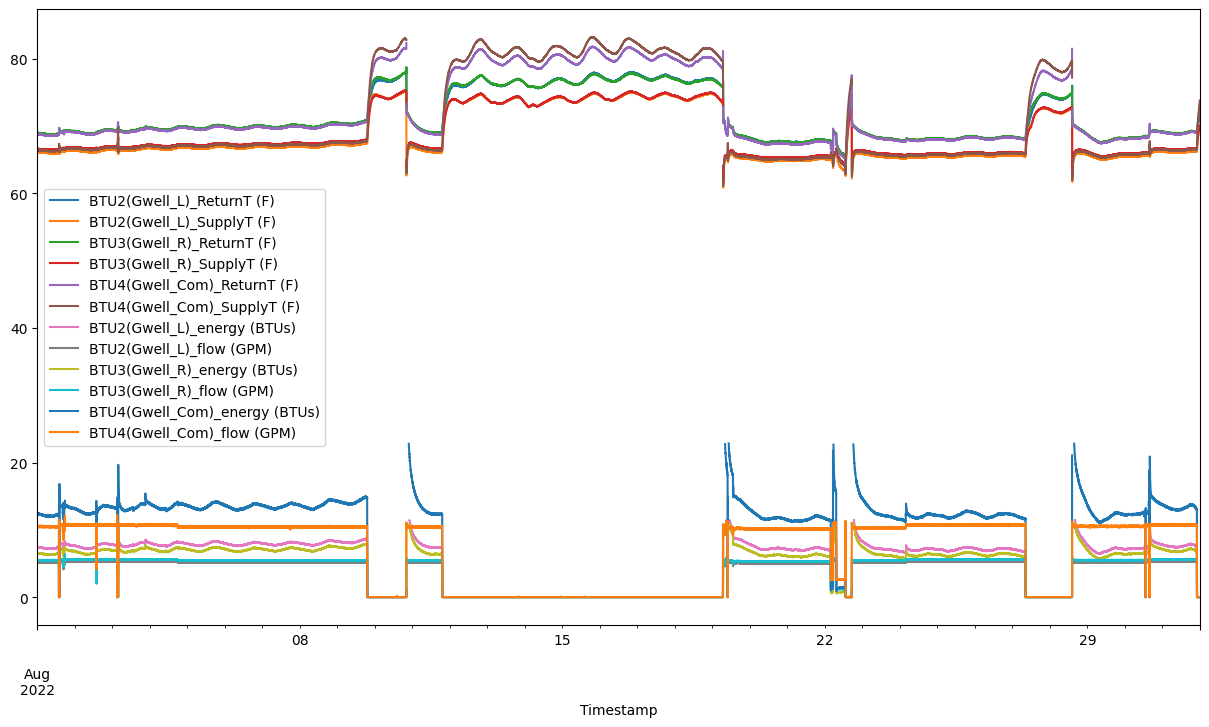

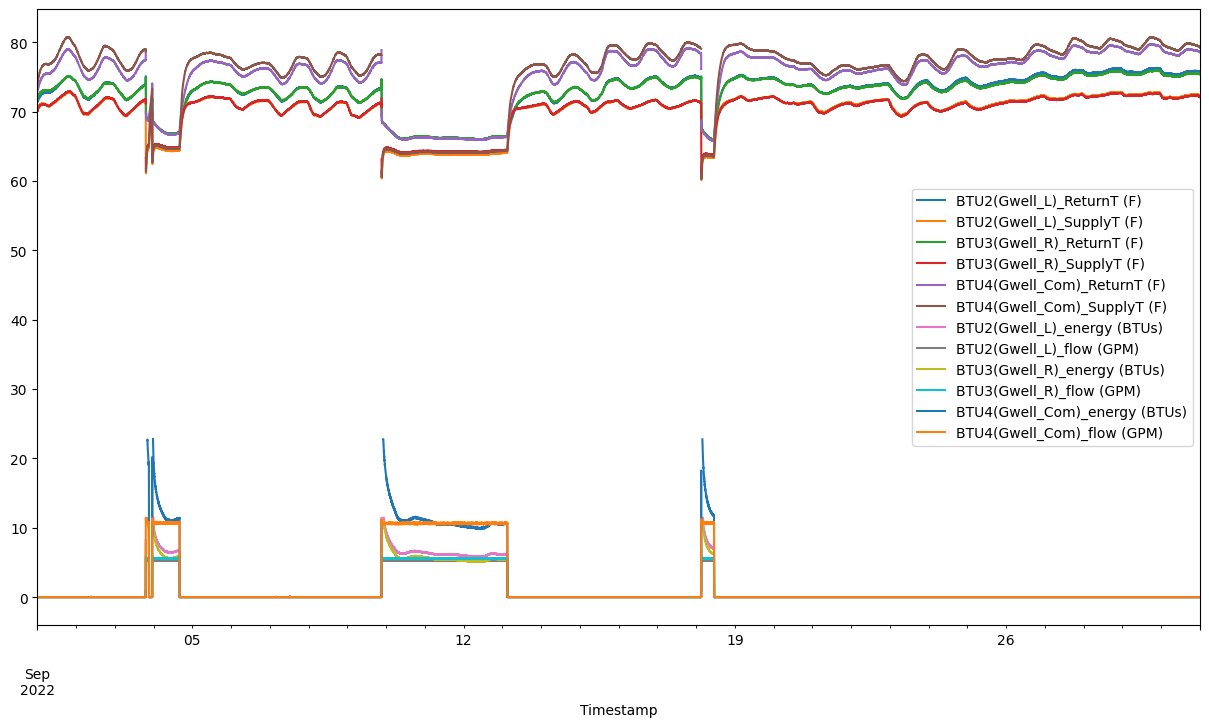

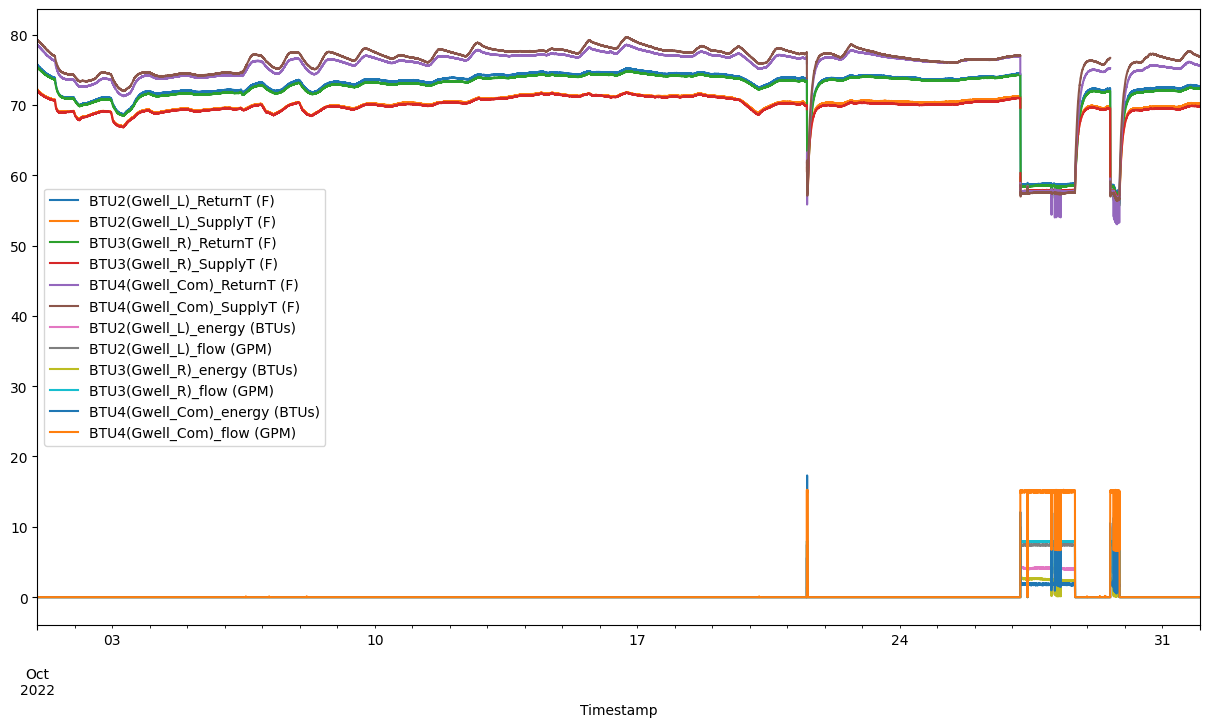

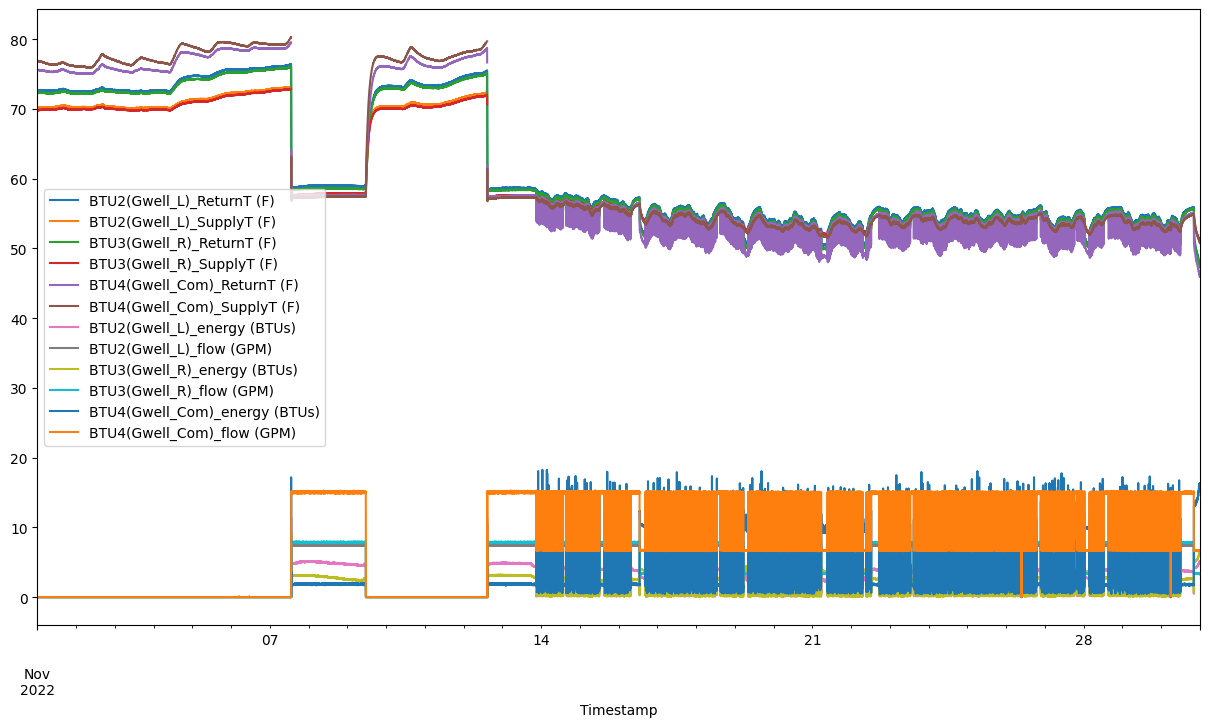

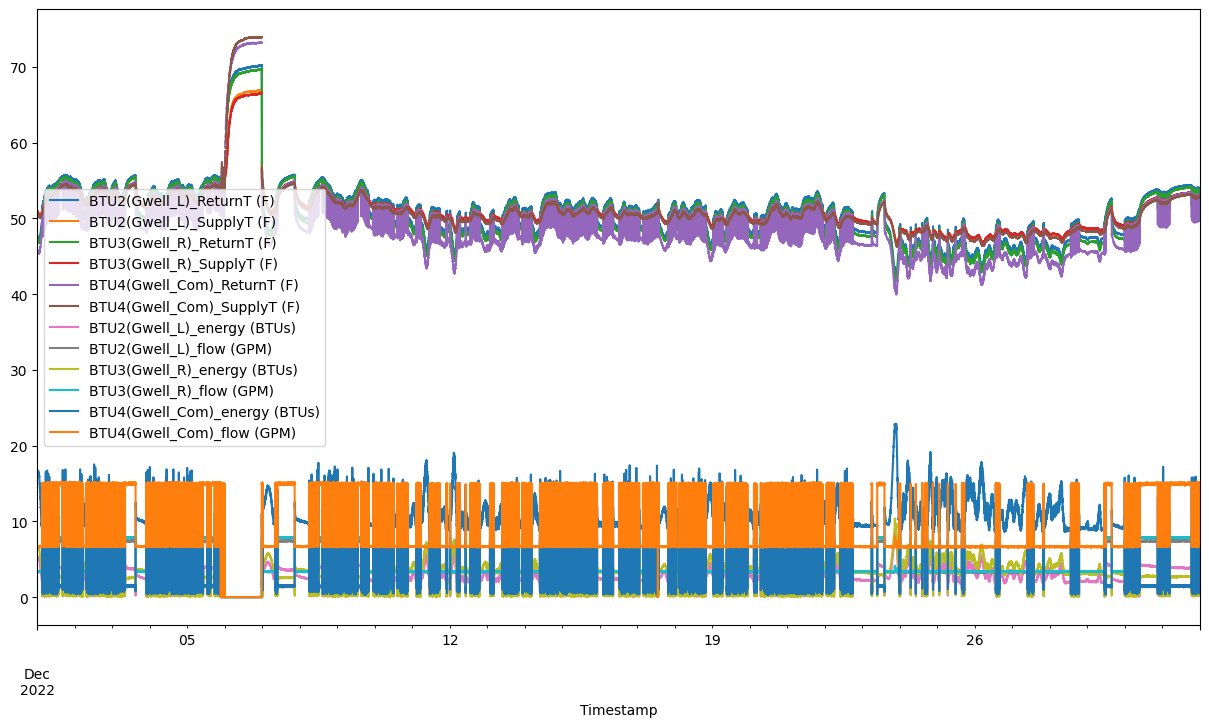

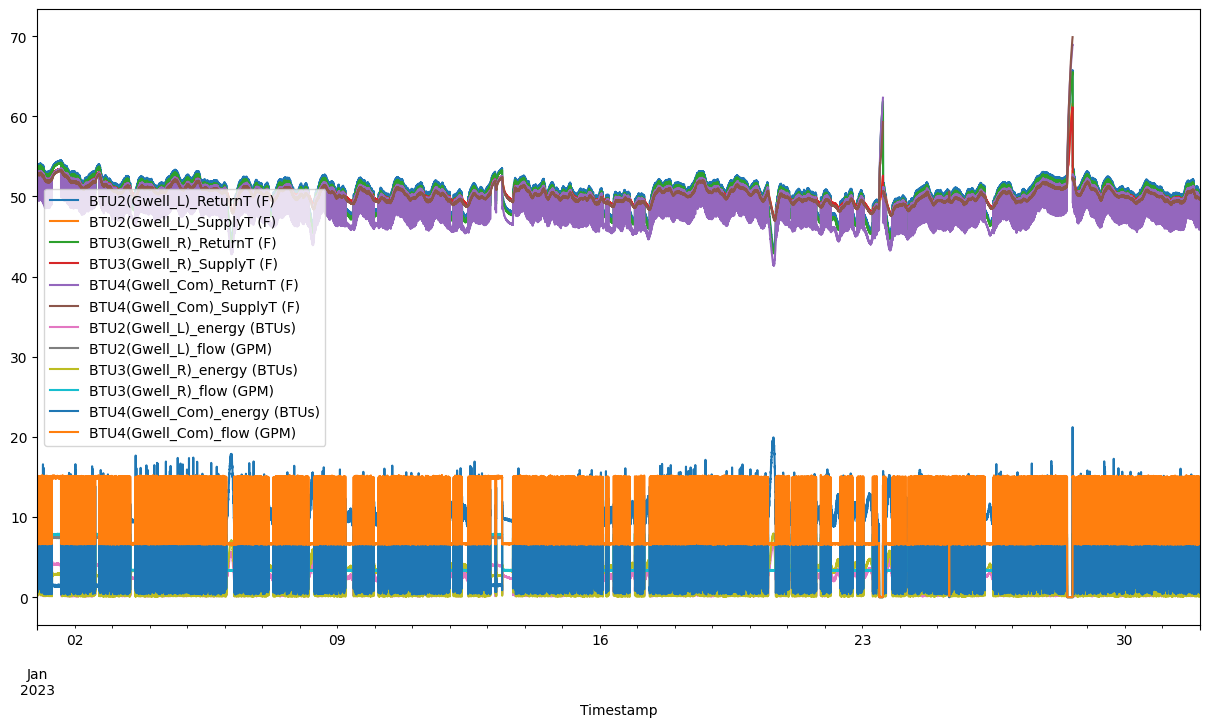

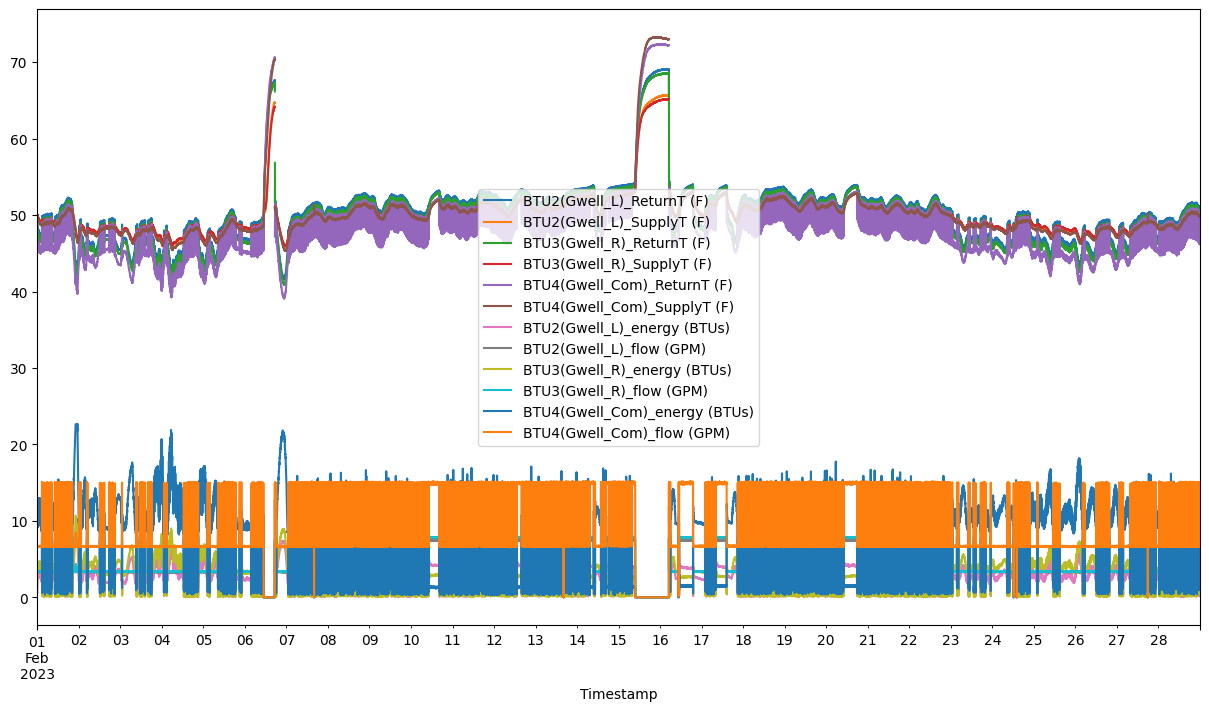

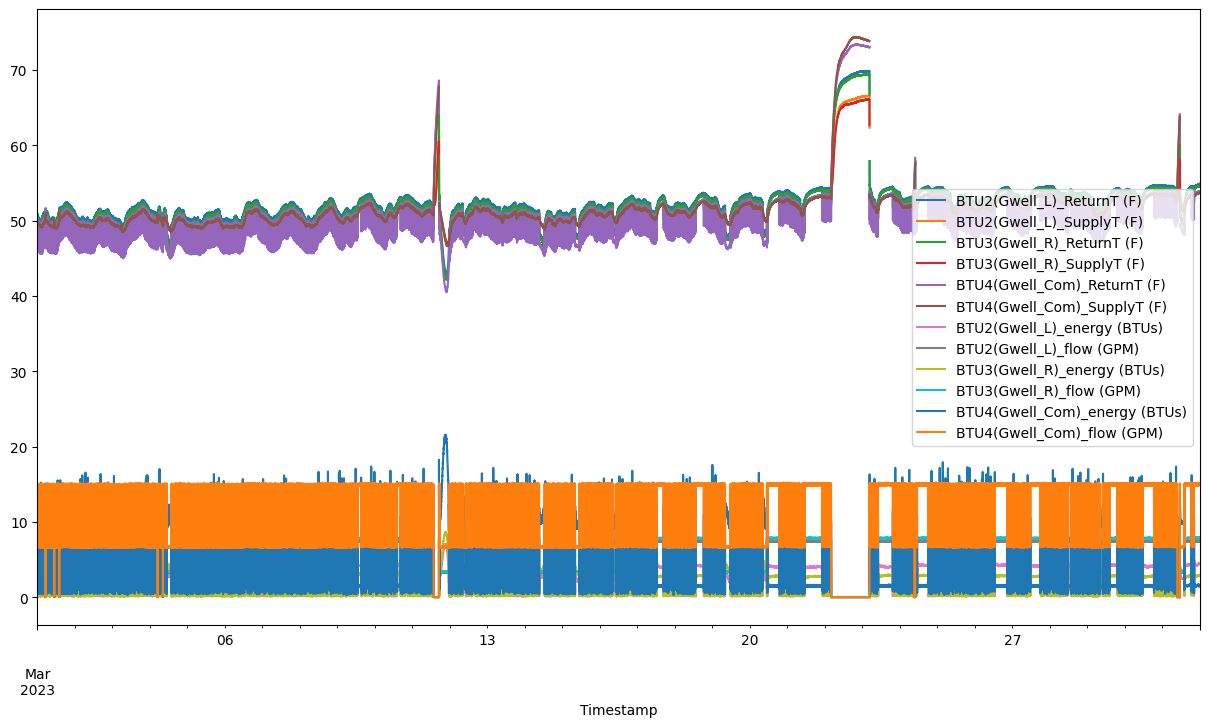

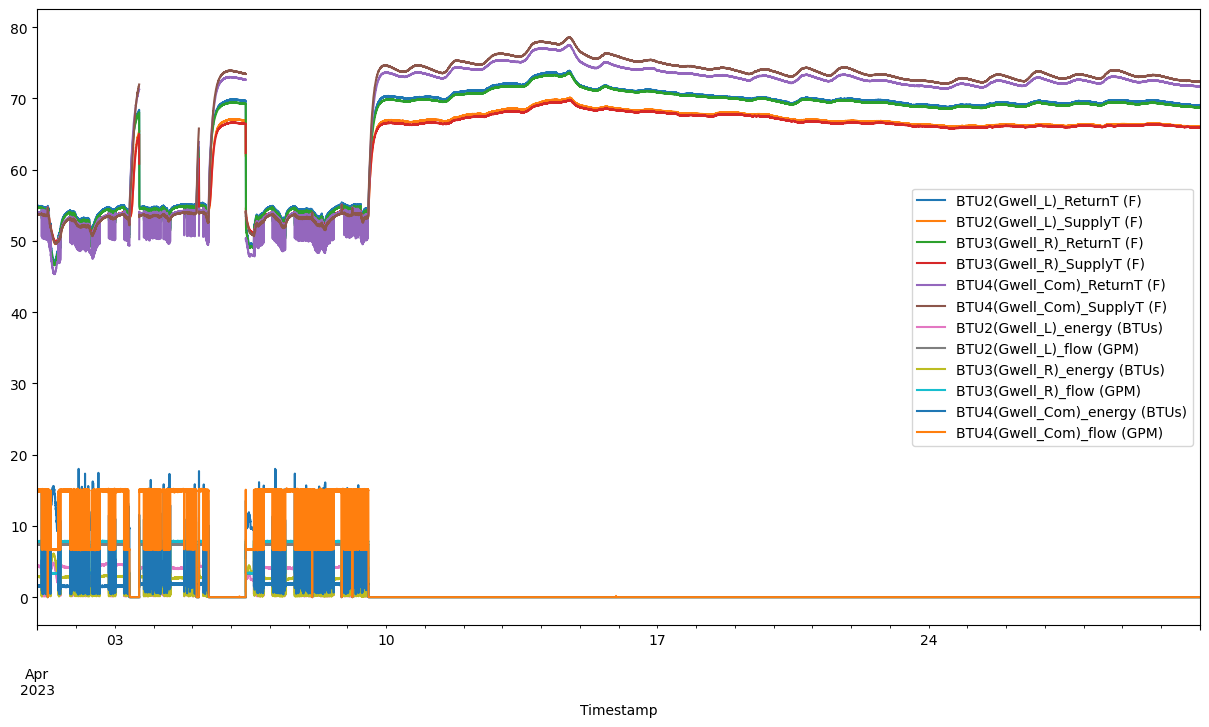

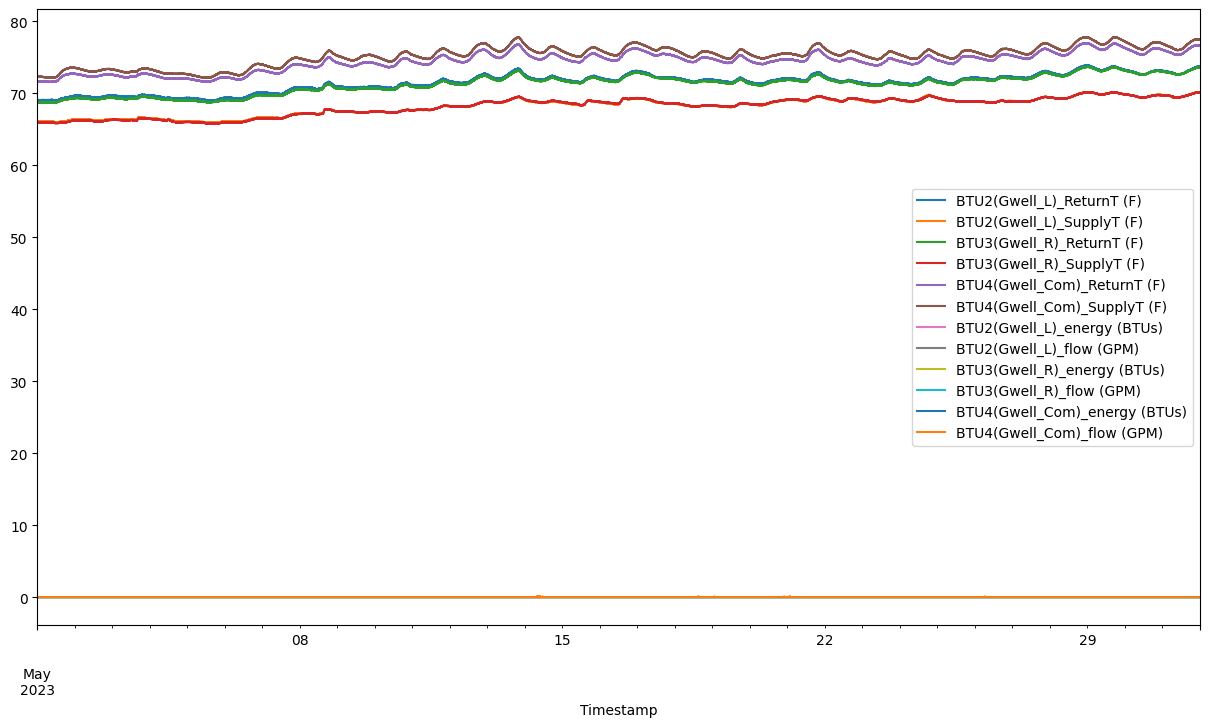

In [34]:
for (year, month), group in df_total.groupby([df_total.index.year, df_total.index.month]):

    group.plot(figsize=(15, 8))

C:\Users\Sang\AppData\Local\Temp\ipykernel_7324\3466276560.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_total = df_total.resample("H").mean().ffill()


<Axes: xlabel='Timestamp'>

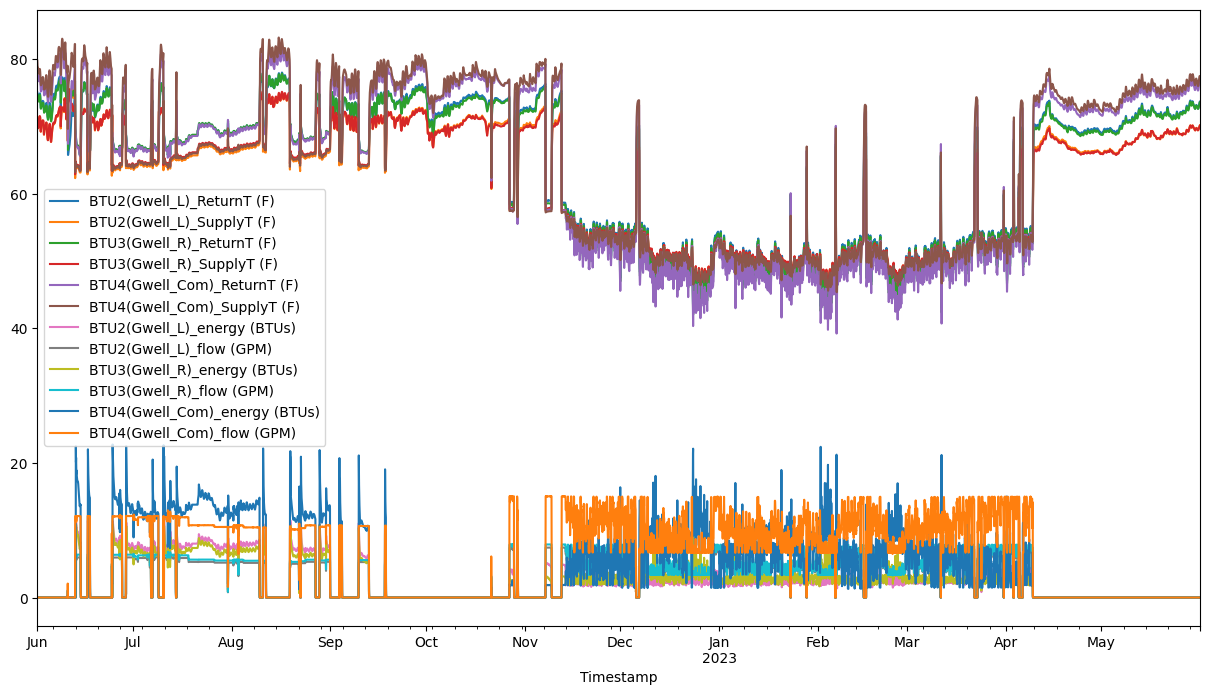

In [35]:
#Process to Hourly and forward fill (average to hour and forward fill to assign last existing value to a missing value)
df_total = df_total.resample("H").mean().ffill()

df_total.plot(figsize=(15, 8))

In [36]:
#Missing data check code
def find_nan_sequences(series):
    is_nan = series.isna()
    if is_nan.any():
        start = end = None
        for i, val in enumerate(is_nan):
            if val and start is None:
                start = i
            elif not val and start is not None:
                end = i - 1
                yield (series.index[start], series.index[end])
                start = end = None
        if start is not None:
            yield (series.index[start], series.index[-1])

# Find and print start and end indices of NaN sequences in each column
empDF = pd.DataFrame()
LstN = []
LstS = []
LstE = []

for column in df_total.columns:
    for start, end in find_nan_sequences(df_total[column]):
        print(f"Missing period:'{column}' from {start} to {end}")
        LstN.append(column)
        LstS.append(start)
        LstE.append(end)
        
empDF["names"] = LstN
empDF["start"] = LstS
empDF["end"] = LstE

In [37]:
empDF.to_csv(r'C:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Final_Processing_Code_2024\Missing Intervals\Year3\Missing_periods_BTU_GEO_Year3.csv', index=False)

In [38]:
#To csv for processed data
df_total.to_csv(r'C:\Users\Sang\OneDrive - Harvard University\CGBC\DataRelease\Final_Processing_Code_2024\Processed\Year3\Zone_BTU_GEO_Year3.csv', index=True)